In [ ]:
import os
# Navigate to a working directory, e.g., /content
os.chdir('/content')
# Unzip dataset
!unzip "/content/drive/MyDrive/MANGOPROJECT/CauseOfDamageMangoDataset.v1i.yolov11.zip" -d "/content/dataset"

Streaming output truncated to the last 5000 lines.
 extracting: /content/dataset/train/images/20220510_124612_jpg.rf.4201f252d9d832243027087457747944.jpg  
 extracting: /content/dataset/train/images/20220510_124612_jpg.rf.a817629e8d36fa50e4ca50d4c8ec5bc3.jpg  
 extracting: /content/dataset/train/images/20220510_124640_jpg.rf.39c08bddb79555492733b39ef977e064.jpg  
 extracting: /content/dataset/train/images/20220510_124640_jpg.rf.46c0a6e3d33ebeafe8839cf6b71a6362.jpg  
 extracting: /content/dataset/train/images/20220510_124640_jpg.rf.56fe049a45b394146a20c5c05db11a57.jpg  
 extracting: /content/dataset/train/images/20220510_125047_jpg.rf.4050a6ded03103925e78963d6db91ad9.jpg  
 extracting: /content/dataset/train/images/20220510_125047_jpg.rf.97477fef5e0abaecf65688da7f430643.jpg  
 extracting: /content/dataset/train/images/20220510_125047_jpg.rf.f2726566cbc300ad2066ae025016a236.jpg  
 extracting: /content/dataset/train/images/20220510_125100_jpg.rf.c7d85f920cd30c7cfd705cfe7fcc0d4b.jpg  
 ext


--- Processing subset: train ---
Processing: /content/dataset/train/images/20220506_102014_jpg.rf.690a808ac86891f179a01526d1eb8cfa.jpg
No contained annotations for mango 0 in /content/dataset/train/images/20220506_102014_jpg.rf.690a808ac86891f179a01526d1eb8cfa.jpg
Processing: /content/dataset/train/images/20220506_102014_jpg.rf.cc47cde48fb67b1757412910247ddd94.jpg
No contained annotations for mango 0 in /content/dataset/train/images/20220506_102014_jpg.rf.cc47cde48fb67b1757412910247ddd94.jpg
Processing: /content/dataset/train/images/20220506_102014_jpg.rf.e1df64a8549e4d89f40d33e09a9f5630.jpg
No contained annotations for mango 0 in /content/dataset/train/images/20220506_102014_jpg.rf.e1df64a8549e4d89f40d33e09a9f5630.jpg
Processing: /content/dataset/train/images/20220506_102147_jpg.rf.17dfdfcb9410b47385e843f8ed76cdc1.jpg

=== Sample from 20220506_102147_jpg.rf.17dfdfcb9410b47385e843f8ed76cdc1_mango_0.txt ===
0 0.5 0.5 1.0 1.0



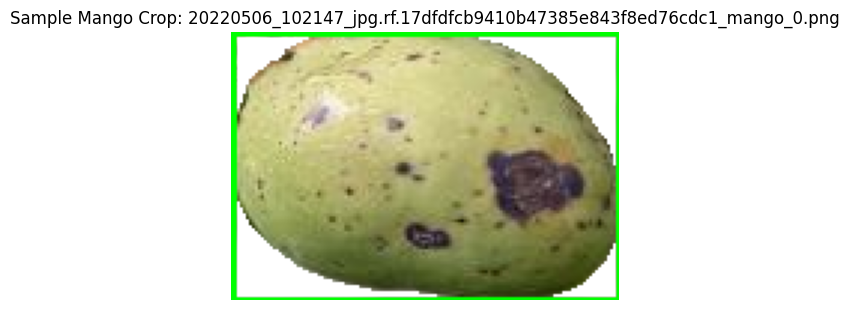

Streaming output truncated to the last 5000 lines.
No contained annotations for mango 1 in /content/dataset/train/images/20220508_124517_jpg.rf.f56bc9cad42b8c59a47859838ab4cf2a.jpg
Processing: /content/dataset/train/images/20220508_124643_jpg.rf.1815ba8a877a9fc55ca9e3ca38b893c0.jpg
No contained annotations for mango 0 in /content/dataset/train/images/20220508_124643_jpg.rf.1815ba8a877a9fc55ca9e3ca38b893c0.jpg
Processing: /content/dataset/train/images/20220508_124643_jpg.rf.1f51de9b8ee5be49146f0b47a56e70a7.jpg
No contained annotations for mango 0 in /content/dataset/train/images/20220508_124643_jpg.rf.1f51de9b8ee5be49146f0b47a56e70a7.jpg
Processing: /content/dataset/train/images/20220508_124643_jpg.rf.5e261bd7ccc97576fda112a9c6392dcc.jpg
No contained annotations for mango 0 in /content/dataset/train/images/20220508_124643_jpg.rf.5e261bd7ccc97576fda112a9c6392dcc.jpg
Processing: /content/dataset/train/images/20220508_124811_jpg.rf.0fa8c1a713b3b8fe443f01a68af6f685.jpg
No contained annotati

In [ ]:
import os
import glob
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

########################
# Configuration
########################
base_input_path = '/content/dataset'           # Original YOLO dataset root
base_output_path = '/content/processed_dataset'  # Where to save processed (single-mango) images
subsets = ['train', 'test', 'valid']
MANGO_CLASS = 6  # The class index for "mango" as defined in your data.yaml

# Load original data.yaml to get class names
data_yaml_path = os.path.join(base_input_path, 'data.yaml')
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
classes = data_yaml.get('names', [])

# Create a mapping from old class indices to new ones (removing mango class)
old_to_new_class = {}
new_classes = []
new_idx = 0
for idx, class_name in enumerate(classes):
    if idx == MANGO_CLASS:
        old_to_new_class[idx] = None  # Mango class is removed
    else:
        old_to_new_class[idx] = new_idx
        new_classes.append(class_name)
        new_idx += 1

# Create output directories for each subset
for subset in subsets:
    os.makedirs(os.path.join(base_output_path, subset, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_output_path, subset, 'labels'), exist_ok=True)

# Global state
sample_shown = False   # Only display one sample crop
processed_count = 0    # Counter for total processed mango images

########################
# Parsing Functions
########################
def parse_annotation_line(line):
    """
    Parses a single line from a label file.
    - If exactly 5 numbers are found, it is assumed to be YOLO bbox format:
          class_id, x_center, y_center, width, height
      and converts that to a rectangle polygon.
    - Otherwise, it is assumed to be polygon format:
          class_id, x1, y1, x2, y2, ..., xN, yN
    Returns:
          (class_id, polygon)
    where polygon is a list of (x, y) pairs in normalized coordinates.
    """
    parts = line.strip().split()
    if not parts:
        return None
    class_id = int(parts[0])
    coords = list(map(float, parts[1:]))
    if len(coords) == 4:
        x_center, y_center, width, height = coords
        xmin = x_center - width / 2
        ymin = y_center - height / 2
        xmax = x_center + width / 2
        ymax = y_center + height / 2
        polygon = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
    else:
        if len(coords) % 2 != 0:
            print("Warning: uneven coordinate count; skipping line:", line)
            return None
        polygon = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
    return (class_id, polygon)

def polygon_to_bbox_norm(polygon):
    """
    Given a list of (x, y) points (normalized), returns the bounding box
    in normalized coordinates: (xmin, ymin, xmax, ymax).
    """
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]
    return (min(xs), min(ys), max(xs), max(ys))

def process_annotations(label_file, img_width, img_height):
    """
    Reads a label file and returns a list of annotations as tuples:
          (class_id, xmin, ymin, xmax, ymax, polygon)
    where the bbox coordinates are in absolute pixels (using img_width and img_height)
    and polygon remains in normalized coordinates.
    """
    annotations = []
    with open(label_file, 'r') as f:
        for line in f:
            parsed = parse_annotation_line(line)
            if parsed is None:
                continue
            class_id, polygon = parsed
            xmin_n, ymin_n, xmax_n, ymax_n = polygon_to_bbox_norm(polygon)
            xmin = int(xmin_n * img_width)
            ymin = int(ymin_n * img_height)
            xmax = int(xmax_n * img_width)
            ymax = int(ymax_n * img_height)
            annotations.append((class_id, xmin, ymin, xmax, ymax, polygon))
    return annotations

########################
# Mask Creation
########################
def create_masked_image_polygon(img, polygon, bbox, image_path):
    """
    Crops the image 'img' to the given 'bbox' and creates a masked image (BGRA)
    such that pixels outside the polygon (provided in normalized coords) become transparent.
    """
    x_min, y_min, x_max, y_max = bbox
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.shape[1], x_max)
    y_max = min(img.shape[0], y_max)

    roi = img[y_min:y_max, x_min:x_max]
    if roi.size == 0:
        print(f"Empty ROI for bbox {bbox} in image {image_path}")
        return None

    roi_bgra = cv2.cvtColor(roi, cv2.COLOR_BGR2BGRA)

    # Convert normalized polygon to absolute coordinates relative to the entire image,
    # then shift to ROI coordinates by subtracting (x_min, y_min)
    abs_poly = []
    h, w = img.shape[:2]
    for (px, py) in polygon:
        abs_x = int(px * w) - x_min
        abs_y = int(py * h) - y_min
        abs_poly.append([abs_x, abs_y])

    mask = np.zeros(roi.shape[:2], dtype=np.uint8)
    pts = np.array([abs_poly], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    roi_bgra[:, :, 3] = mask
    return roi_bgra

########################
# Extraction & Overlay
########################
def extract_fully_contained_annotations(annotations, mango_bbox):
    """
    Returns only those annotations (other than the mango's own) whose bounding boxes are
    completely within the given mango_bbox.
    """
    mx_min, my_min, mx_max, my_max = mango_bbox
    contained = []
    for ann in annotations:
        c_id, x_min, y_min, x_max, y_max, poly = ann
        if c_id == MANGO_CLASS:  # Skip the mango class
            continue
        if x_min >= mx_min and y_min >= my_min and x_max <= mx_max and y_max <= my_max:
            contained.append(ann)
    return contained

def overlay_annotations(img_bgra, annotations):
    """
    Draws bounding boxes for 'annotations' on the cropped BGRA image.
    Assumes the coordinates in 'annotations' are already adjusted to the new coordinate system.
    """
    annotated = img_bgra.copy()
    for ann in annotations:
        c_id, x_min, y_min, x_max, y_max, poly = ann
        # Get the original class name using the original class index
        label = classes[c_id] if 0 <= c_id < len(classes) else f"class_{c_id}"
        pt1 = (int(x_min), int(y_min))
        pt2 = (int(x_max), int(y_max))
        cv2.rectangle(annotated, pt1, pt2, (0, 255, 0, 255), 2)
        cv2.putText(annotated, label, (pt1[0], pt1[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0,255), 2)
    return annotated

########################
# Processing Function
########################
def process_and_visualize_image(image_path, label_file, out_img_dir, out_lbl_dir):
    global sample_shown, processed_count

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error loading image: {image_path}")
        return
    h, w = img.shape[:2]
    base_name = Path(image_path).stem

    if not os.path.exists(label_file):
        print(f"No label for {image_path}")
        return

    ann_list = process_annotations(label_file, w, h)

    # Process each mango instance (MANGO_CLASS)
    for idx, ann in enumerate(ann_list):
        c_id, x_min, y_min, x_max, y_max, poly = ann
        if c_id != MANGO_CLASS:
            continue
        bbox = (x_min, y_min, x_max, y_max)
        mango_bgra = create_masked_image_polygon(img, poly, bbox, image_path)
        if mango_bgra is None:
            print(f"Skipping mango {idx} in {image_path} due to invalid ROI.")
            continue

        # Extract other annotations fully contained in the mango bbox
        contained = extract_fully_contained_annotations(ann_list, bbox)
        if not contained:
            print(f"No contained annotations for mango {idx} in {image_path}")
            continue

        # Adjust contained annotation coordinates to the new crop coordinate system
        adjusted = []
        for c_ann in contained:
            c2_id, cx_min, cy_min, cx_max, cy_max, c_poly = c_ann
            # Apply class mapping to remove mango class and remap indices
            new_c_id = old_to_new_class.get(c2_id)
            if new_c_id is None:  # Skip if this class should be eliminated
                continue

            new_ann = (new_c_id, cx_min - x_min, cy_min - y_min, cx_max - x_min, cy_max - y_min, c_poly)
            # Ensure the new coordinates are clipped to [0, region_w] and [0, region_h]
            region_w = x_max - x_min
            region_h = y_max - y_min
            new_ann = (new_c_id,
                       max(0, min(new_ann[1], region_w)),
                       max(0, min(new_ann[2], region_h)),
                       max(0, min(new_ann[3], region_w)),
                       max(0, min(new_ann[4], region_h)),
                       c_poly)
            adjusted.append(new_ann)

        # Skip if no valid annotations after class remapping
        if not adjusted:
            print(f"No valid annotations after class remapping for mango {idx} in {image_path}")
            continue

        # Overlay contained annotations on the crop.
        annotated_bgra = overlay_annotations(mango_bgra, adjusted)
        out_img_path = os.path.join(out_img_dir, f"{base_name}_mango_{idx}.png")
        cv2.imwrite(out_img_path, annotated_bgra)

        # Save new YOLO-format labels for the crop
        region_w = float(x_max - x_min)
        region_h = float(y_max - y_min)
        out_lbl_path = os.path.join(out_lbl_dir, f"{base_name}_mango_{idx}.txt")
        with open(out_lbl_path, 'w') as f:
            for ad in adjusted:
                c2_id, nx_min, ny_min, nx_max, ny_max, _ = ad
                x_c = ((nx_min + nx_max) / 2.0) / region_w
                y_c = ((ny_min + ny_max) / 2.0) / region_h
                w_norm = (nx_max - nx_min) / region_w
                h_norm = (ny_max - ny_min) / region_h
                f.write(f"{c2_id} {x_c} {y_c} {w_norm} {h_norm}\n")

        processed_count += 1

        if not sample_shown:
            print(f"\n=== Sample from {Path(out_lbl_path).name} ===")
            with open(out_lbl_path, 'r') as s:
                print(s.read())
            disp_img = cv2.cvtColor(annotated_bgra, cv2.COLOR_BGRA2RGBA)
            plt.figure(figsize=(5,5))
            plt.imshow(disp_img)
            plt.title(f"Sample Mango Crop: {Path(out_img_path).name}")
            plt.axis('off')
            plt.show()
            sample_shown = True

########################
# Main Loop
########################
for subset in subsets:
    print(f"\n--- Processing subset: {subset} ---")
    img_dir = os.path.join(base_input_path, subset, 'images')
    lbl_dir = os.path.join(base_input_path, subset, 'labels')
    out_img_dir = os.path.join(base_output_path, subset, 'images')
    out_lbl_dir = os.path.join(base_output_path, subset, 'labels')

    image_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
    label_files = glob.glob(os.path.join(lbl_dir, '**/*.txt'), recursive=True)

    images_by_base = {Path(x).stem.lower(): x for x in image_files}
    labels_by_base = {Path(x).stem.lower(): x for x in label_files}

    common_bases = sorted(set(images_by_base.keys()) & set(labels_by_base.keys()))
    if not common_bases:
        print(f"No matching pairs found for subset {subset}")
        continue

    for base_nm in common_bases:
        img_path = images_by_base[base_nm]
        lbl_path = labels_by_base[base_nm]
        print(f"Processing: {img_path}")
        process_and_visualize_image(img_path, lbl_path, out_img_dir, out_lbl_dir)

print(f"\nTotal processed mango images: {processed_count}")

########################
# Create new data.yaml for processed dataset
########################
new_yaml = {
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': len(new_classes),  # Updated class count
    'names': new_classes     # Updated class list without mango
}
out_yaml_path = os.path.join(base_output_path, 'data.yaml')
with open(out_yaml_path, 'w') as f:
    yaml.safe_dump(new_yaml, f)
print(f"New data.yaml created at: {out_yaml_path}")
print(f"Original classes: {classes}")
print(f"New classes (mango removed): {new_classes}")

####

Copied valid set as-is
Copied test set as-is
Classes: ['Anthracnose', 'Bacterial-Black-spot', 'Damaged-mango', 'Fruitly', 'Mechanical-damage', 'Others']

--- Processing train set ---


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Analyzing train set:   0%|          | 0/913 [00:00<?, ?it/s]


Initial class distribution:
Class 0 (Anthracnose): 608 annotations
Class 1 (Bacterial-Black-spot): 236 annotations
Class 3 (Fruitly): 605 annotations
Class 4 (Mechanical-damage): 14 annotations
Class 5 (Others): 81 annotations


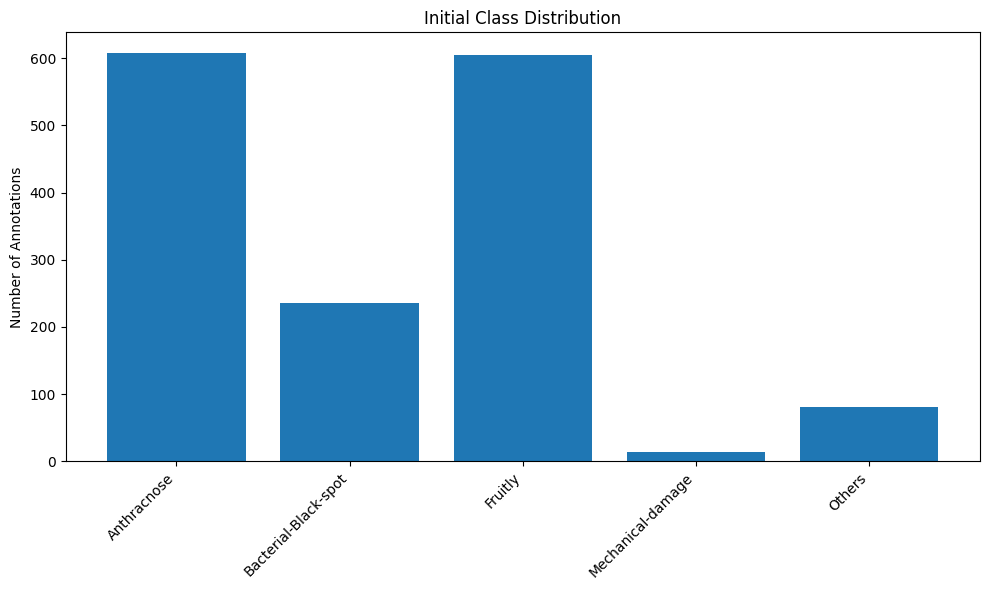


Augmentations needed per class:
Class 0 (Anthracnose): 192 more samples needed
Class 1 (Bacterial-Black-spot): 664 more samples needed
Class 3 (Fruitly): No augmentation needed
Class 4 (Mechanical-damage): 386 more samples needed
Class 5 (Others): 219 more samples needed

Copying original files...


  0%|          | 0/913 [00:00<?, ?it/s]


Generating augmented samples...
Augmenting class 0 (Anthracnose): 192 samples needed, 500 source images


  0%|          | 0/192 [00:00<?, ?it/s]

Created 192/192 augmented samples for class 0 (Anthracnose) after 192 attempts
Augmenting class 1 (Bacterial-Black-spot): 664 samples needed, 182 source images


  0%|          | 0/664 [00:00<?, ?it/s]

Created 664/664 augmented samples for class 1 (Bacterial-Black-spot) after 665 attempts
Augmenting class 4 (Mechanical-damage): 386 samples needed, 12 source images


  0%|          | 0/386 [00:00<?, ?it/s]

Created 386/386 augmented samples for class 4 (Mechanical-damage) after 387 attempts
Augmenting class 5 (Others): 219 samples needed, 78 source images


  0%|          | 0/219 [00:00<?, ?it/s]

Created 219/219 augmented samples for class 5 (Others) after 219 attempts

Limiting overrepresented classes...
Limiting class 0 from 956 to 800 annotations (removing 156)
Removed 117 files containing 156 annotations of class 0
Limiting class 1 from 1004 to 900 annotations (removing 104)
Removed 25 files containing 104 annotations of class 1
Limiting class 4 from 433 to 400 annotations (removing 33)
Removed 17 files containing 34 annotations of class 4
Limiting class 5 from 398 to 300 annotations (removing 98)
Removed 98 files containing 98 annotations of class 5

Verifying final class distribution...


Analyzing train set:   0%|          | 0/2117 [00:00<?, ?it/s]


Final class distribution:
Class 0 (Anthracnose): 781 annotations
Class 1 (Bacterial-Black-spot): 900 annotations
Class 3 (Fruitly): 1046 annotations
Class 4 (Mechanical-damage): 368 annotations
Class 5 (Others): 300 annotations


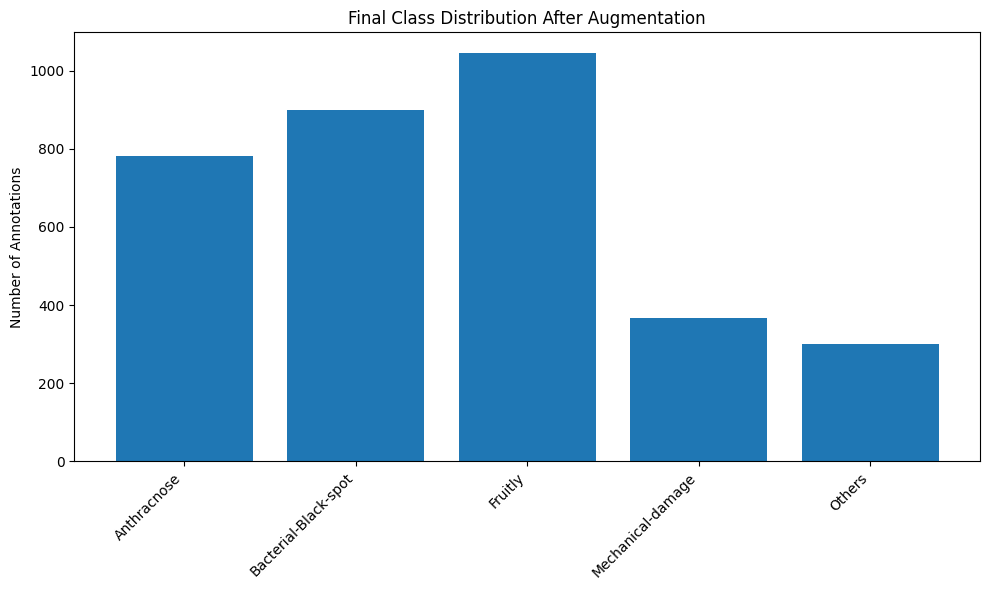


Balanced dataset created at: /content/balanced_dataset
New data.yaml created at: /content/balanced_dataset/data.yaml


In [ ]:
import os
import glob
import random
import shutil
import numpy as np
import cv2
import yaml
from pathlib import Path
from tqdm.auto import tqdm
from collections import Counter
import matplotlib.pyplot as plt
import albumentations as A

# Configuration
processed_dataset_path = '/content/processed_dataset'  # Path to your processed dataset without mango class
balanced_dataset_path = '/content/balanced_dataset'    # Where to save the balanced dataset
subsets = ['train']  # Only balance the training set, keep validation and test as is
target_min_samples = 500  # Minimum number of samples per class after augmentation

# Custom targets for specific classes
custom_targets = {
    0: 800,   # Limit Anthracnose class to 800
    1: 900,   # Limit Bacterial-Black-spot class to 900
    4: 400,   # Minimum 400 for Mechanical damage
    5: 300    # Limit Others to 900
}

# Create output directories
for subset in subsets:
    os.makedirs(os.path.join(balanced_dataset_path, subset, 'images'), exist_ok=True)
    os.makedirs(os.path.join(balanced_dataset_path, subset, 'labels'), exist_ok=True)

# For validation and test sets, just copy them as they are
for subset in ['valid', 'test']:
    if os.path.exists(os.path.join(processed_dataset_path, subset)):
        shutil.copytree(
            os.path.join(processed_dataset_path, subset),
            os.path.join(balanced_dataset_path, subset),
            dirs_exist_ok=True
        )
        print(f"Copied {subset} set as-is")

# Load data.yaml to get class names
with open(os.path.join(processed_dataset_path, 'data.yaml'), 'r') as f:
    data_yaml = yaml.safe_load(f)

classes = data_yaml['names']
print(f"Classes: {classes}")

# Define augmentation pipelines with increasing intensity
augmentation_pipelines = [
    # Pipeline 1: Light augmentation - suitable for all bounding boxes
    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.7),
        A.GaussianBlur(blur_limit=(3, 5), p=0.3),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_area=0.0001, min_visibility=0.1)),

    # Pipeline 2: Moderate augmentation - safer transformations for small boxes
    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
        A.GaussianBlur(blur_limit=(3, 7), p=0.4),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_area=0.0001, min_visibility=0.1)),

    # Pipeline 3: Strong augmentation - but still relatively safe
    A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.9),
        A.GaussianBlur(blur_limit=(3, 9), p=0.5),
        A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=0.7),
        A.RandomShadow(p=0.5),
        A.CLAHE(p=0.5),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['class_labels'], min_area=0.0001, min_visibility=0.1)),
]

def count_class_distribution(subset='train', dataset_path=None):
    """Count the occurrences of each class in the labels"""
    if dataset_path is None:
        dataset_path = processed_dataset_path

    label_files = glob.glob(os.path.join(dataset_path, subset, 'labels', '*.txt'))
    class_counts = Counter()

    # Keep track of images containing each class
    class_to_images = {cls_idx: [] for cls_idx in range(len(classes))}

    for label_file in tqdm(label_files, desc=f"Analyzing {subset} set"):
        img_classes = set()  # Track unique classes in this image

        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts:
                    # Fix for the "5.0" issue - make sure class_id is an integer
                    try:
                        class_id = int(float(parts[0]))
                        class_counts[class_id] += 1
                        img_classes.add(class_id)
                    except ValueError as e:
                        print(f"Warning: Invalid class ID in {label_file}: {parts[0]}")
                        continue

        # Add this image to the list for each class it contains
        base_name = Path(label_file).stem
        img_path = os.path.join(dataset_path, subset, 'images', f"{base_name}.png")
        if os.path.exists(img_path):
            for cls_id in img_classes:
                class_to_images[cls_id].append((img_path, label_file))

    return class_counts, class_to_images

def is_valid_bbox(bbox):
    """Check if a bounding box is valid (non-zero width and height)"""
    x_center, y_center, width, height = bbox
    # YOLO format has normalized coordinates
    # Make sure width and height are non-zero and reasonable
    return width > 0.001 and height > 0.001

def fix_bboxes(bboxes, class_labels):
    """Filter out invalid bounding boxes and their labels"""
    valid_bboxes = []
    valid_labels = []

    for i, (bbox, label) in enumerate(zip(bboxes, class_labels)):
        if is_valid_bbox(bbox):
            valid_bboxes.append(bbox)
            valid_labels.append(label)

    return valid_bboxes, valid_labels

def apply_augmentation(img_path, label_path, output_img_path, output_label_path, pipeline):
    """Apply augmentation to an image and its annotations"""
    # Read the image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error loading image: {img_path}")
        return False

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Read the labels
    bboxes = []
    class_labels = []

    with open(label_path, 'r') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) >= 5:  # YOLO format: class_id, x_center, y_center, width, height
                try:
                    class_id = int(float(parts[0]))  # Fix for the "5.0" issue
                    x_center, y_center, width, height = map(float, parts[1:5])

                    # Skip boxes with zero width or height
                    if width <= 0 or height <= 0:
                        continue

                    # Ensure box dimensions are not too small - add a tiny epsilon
                    width = max(width, 0.001)
                    height = max(height, 0.001)

                    bboxes.append([x_center, y_center, width, height])
                    class_labels.append(class_id)
                except ValueError:
                    print(f"Warning: Invalid line in {label_path}: {line.strip()}")
                    continue

    if not bboxes:
        return False

    # Double-check bboxes are valid
    bboxes, class_labels = fix_bboxes(bboxes, class_labels)

    if not bboxes:
        return False

    # Apply augmentation
    try:
        transformed = pipeline(image=image, bboxes=bboxes, class_labels=class_labels)
        transformed_image = transformed['image']
        transformed_bboxes = transformed['bboxes']
        transformed_class_labels = transformed['class_labels']
    except Exception as e:
        # Print debugging information
        print(f"Error applying augmentation: {e}")
        # Skip this augmentation and try another
        return False

    # Additional safety check - sometimes augmentation can result in invalid boxes
    if not transformed_bboxes or len(transformed_bboxes) == 0:
        return False

    # Save augmented image
    transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
    cv2.imwrite(output_img_path, transformed_image)

    # Save augmented labels
    with open(output_label_path, 'w') as f:
        for i, (box, cls_id) in enumerate(zip(transformed_bboxes, transformed_class_labels)):
            x_center, y_center, width, height = box
            f.write(f"{cls_id} {x_center} {y_center} {width} {height}\n")

    return True

def limit_dataset_by_class(subset, class_id, max_count, balanced_path, processed_path):
    """
    Limit the number of annotations for a specific class by removing excess images
    containing that class to bring the count under the specified maximum.
    """
    # Get all label files in the balanced dataset
    label_files = glob.glob(os.path.join(balanced_path, subset, 'labels', '*.txt'))
    random.shuffle(label_files)  # Randomize to avoid bias

    # Count annotations per file for the target class
    class_annotations = []  # [(file_path, count), ...]

    for label_file in label_files:
        base_name = Path(label_file).stem

        # Check if this is an augmented image (we prefer to remove augmentations first)
        is_augmented = "aug" in base_name

        count = 0
        with open(label_file, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if parts and int(float(parts[0])) == class_id:
                    count += 1

        if count > 0:
            # Store whether it's augmented, for sorting priority
            class_annotations.append((label_file, count, is_augmented))

    # Sort by augmentation status first (remove augmented first), then by count (remove high-count files first)
    class_annotations.sort(key=lambda x: (-x[2], -x[1]))

    # Calculate current total
    current_total = sum(count for _, count, _ in class_annotations)
    excess = current_total - max_count

    if excess <= 0:
        print(f"Class {class_id} already within limit ({current_total} <= {max_count})")
        return

    print(f"Limiting class {class_id} from {current_total} to {max_count} annotations (removing {excess})")

    # Remove files until we're under the limit
    removed = 0
    removed_files = 0

    for label_file, count, _ in class_annotations:
        if removed >= excess:
            break

        base_name = Path(label_file).stem
        img_path = os.path.join(balanced_path, subset, 'images', f"{base_name}.png")

        # Remove the file
        os.remove(label_file)
        if os.path.exists(img_path):
            os.remove(img_path)

        removed += count
        removed_files += 1

    print(f"Removed {removed_files} files containing {removed} annotations of class {class_id}")

# Main processing
for subset in subsets:
    print(f"\n--- Processing {subset} set ---")

    # Count class distribution and get images per class
    class_counts, class_to_images = count_class_distribution(subset)

    if not class_counts:
        print(f"No labels found in {subset} set")
        continue

    # Print initial class distribution
    print("\nInitial class distribution:")
    for cls_id, count in sorted(class_counts.items()):
        print(f"Class {cls_id} ({classes[cls_id]}): {count} annotations")

    # Plot initial distribution
    plt.figure(figsize=(10, 6))
    cls_names = [classes[cls_id] for cls_id in sorted(class_counts.keys())]
    counts = [class_counts[cls_id] for cls_id in sorted(class_counts.keys())]
    plt.bar(cls_names, counts)
    plt.title("Initial Class Distribution")
    plt.ylabel("Number of Annotations")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # Calculate how many more samples we need for each class
    augmentations_needed = {}
    for cls_id, count in class_counts.items():
        # Custom target check
        if cls_id in custom_targets:
            target = custom_targets[cls_id]
            # Skip classes that need to be reduced
            if count > target:
                augmentations_needed[cls_id] = 0
                continue
            else:
                augmentations_needed[cls_id] = max(0, target - count)
        else:
            target = target_min_samples
            augmentations_needed[cls_id] = max(0, target - count)

    print("\nAugmentations needed per class:")
    for cls_id, needed in sorted(augmentations_needed.items()):
        if needed > 0:
            print(f"Class {cls_id} ({classes[cls_id]}): {needed} more samples needed")
        else:
            print(f"Class {cls_id} ({classes[cls_id]}): No augmentation needed")

    # Copy all original files to the balanced dataset first
    print("\nCopying original files...")
    image_files = glob.glob(os.path.join(processed_dataset_path, subset, 'images', '*.png'))
    for img_path in tqdm(image_files):
        base_name = Path(img_path).stem
        label_path = os.path.join(processed_dataset_path, subset, 'labels', f"{base_name}.txt")

        if os.path.exists(label_path):
            shutil.copy(img_path, os.path.join(balanced_dataset_path, subset, 'images', f"{base_name}.png"))
            shutil.copy(label_path, os.path.join(balanced_dataset_path, subset, 'labels', f"{base_name}.txt"))

    # Augment classes that need more samples
    print("\nGenerating augmented samples...")
    max_augmentations_per_image = 10  # Maximum augmentations per source image

    for cls_id, needed in sorted(augmentations_needed.items()):
        if needed <= 0:
            continue

        available_images = class_to_images[cls_id]
        if not available_images:
            print(f"Warning: No images found containing class {cls_id} ({classes[cls_id]})")
            continue

        print(f"Augmenting class {cls_id} ({classes[cls_id]}): {needed} samples needed, {len(available_images)} source images")

        # Calculate how many augmentations per image
        augs_per_image = min(max_augmentations_per_image,
                           int(np.ceil(needed / len(available_images))))

        # Shuffle the available images to ensure variety
        random.shuffle(available_images)

        # Track how many augmentations we've created
        created = 0
        attempts = 0
        max_attempts = needed * 3  # Set a maximum number of attempts to prevent infinite loops

        # Generate augmentations
        pbar = tqdm(total=needed)

        # For small classes like Mechanical damage, we need to heavily augment each source image
        if len(available_images) < 5 and needed > 40:
            augs_per_image = min(30, needed)  # Allow more augmentations per image for very small classes

        # Repeat available images enough times to ensure we can meet the target
        image_pool = []
        while len(image_pool) < needed:
            image_pool.extend(available_images)

        for img_path, label_path in image_pool:
            # Break if we've met our target or exceeded maximum attempts
            if created >= needed or attempts >= max_attempts:
                break

            # Try different pipelines in order from safer to riskier
            for pipeline_idx, pipeline in enumerate(augmentation_pipelines):
                if created >= needed or attempts >= max_attempts:
                    break

                # For each image and pipeline, try multiple augmentations
                for aug_idx in range(min(3, augs_per_image)):
                    attempts += 1
                    if created >= needed or attempts >= max_attempts:
                        break

                    base_name = Path(img_path).stem
                    aug_base_name = f"{base_name}_aug_{cls_id}_{created}"

                    output_img_path = os.path.join(balanced_dataset_path, subset, 'images', f"{aug_base_name}.png")
                    output_label_path = os.path.join(balanced_dataset_path, subset, 'labels', f"{aug_base_name}.txt")

                    success = apply_augmentation(img_path, label_path, output_img_path, output_label_path, pipeline)

                    if success:
                        created += 1
                        pbar.update(1)

        pbar.close()
        print(f"Created {created}/{needed} augmented samples for class {cls_id} ({classes[cls_id]}) after {attempts} attempts")

    # Now, limit overrepresented classes
    print("\nLimiting overrepresented classes...")
    for cls_id, target in custom_targets.items():
        limit_dataset_by_class(subset, cls_id, target, balanced_dataset_path, processed_dataset_path)

    # Verify final class distribution in the balanced dataset
    print("\nVerifying final class distribution...")

    # Update paths for counting in the balanced dataset
    final_class_counts, _ = count_class_distribution(subset, balanced_dataset_path)

    print("\nFinal class distribution:")
    for cls_id, count in sorted(final_class_counts.items()):
        print(f"Class {cls_id} ({classes[cls_id]}): {count} annotations")

    # Plot final distribution
    plt.figure(figsize=(10, 6))
    cls_names = [classes[cls_id] for cls_id in sorted(final_class_counts.keys())]
    counts = [final_class_counts[cls_id] for cls_id in sorted(final_class_counts.keys())]
    plt.bar(cls_names, counts)
    plt.title("Final Class Distribution After Augmentation")
    plt.ylabel("Number of Annotations")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Create a new data.yaml for the balanced dataset
balanced_yaml = data_yaml.copy()
balanced_yaml['train'] = 'train/images'
balanced_yaml['val'] = 'valid/images'
balanced_yaml['test'] = 'test/images'

with open(os.path.join(balanced_dataset_path, 'data.yaml'), 'w') as f:
    yaml.safe_dump(balanced_yaml, f)

print(f"\nBalanced dataset created at: {balanced_dataset_path}")
print(f"New data.yaml created at: {os.path.join(balanced_dataset_path, 'data.yaml')}")

##SSD

In [ ]:
import os
import glob
import yaml
import cv2
import numpy as np
import xml.etree.ElementTree as ET
from pathlib import Path
from tqdm.auto import tqdm
import shutil

def create_xml_annotation(image_path, image_width, image_height, boxes, class_ids, class_names):
    """
    Create Pascal VOC format XML annotation file
    """
    root = ET.Element("annotation")

    # Add basic image information
    folder = ET.SubElement(root, "folder")
    folder.text = str(Path(image_path).parent.name)

    filename = ET.SubElement(root, "filename")
    filename.text = str(Path(image_path).name)

    path = ET.SubElement(root, "path")
    path.text = str(image_path)

    source = ET.SubElement(root, "source")
    database = ET.SubElement(source, "database")
    database.text = "Unknown"

    # Add size information
    size = ET.SubElement(root, "size")
    width = ET.SubElement(size, "width")
    width.text = str(image_width)
    height = ET.SubElement(size, "height")
    height.text = str(image_height)
    depth = ET.SubElement(size, "depth")
    depth.text = "3"  # Assuming RGB images

    segmented = ET.SubElement(root, "segmented")
    segmented.text = "0"

    # Add object information for each bounding box
    for box, class_id in zip(boxes, class_ids):
        obj = ET.SubElement(root, "object")

        name = ET.SubElement(obj, "name")
        name.text = class_names[class_id]

        pose = ET.SubElement(obj, "pose")
        pose.text = "Unspecified"

        truncated = ET.SubElement(obj, "truncated")
        truncated.text = "0"

        difficult = ET.SubElement(obj, "difficult")
        difficult.text = "0"

        bndbox = ET.SubElement(obj, "bndbox")

        xmin = ET.SubElement(bndbox, "xmin")
        xmin.text = str(int(box[0]))

        ymin = ET.SubElement(bndbox, "ymin")
        ymin.text = str(int(box[1]))

        xmax = ET.SubElement(bndbox, "xmax")
        xmax.text = str(int(box[2]))

        ymax = ET.SubElement(bndbox, "ymax")
        ymax.text = str(int(box[3]))

    tree = ET.ElementTree(root)
    return tree

def convert_yolo_to_pascal_voc(yolo_dataset_path, output_path, splits=('train', 'val', 'test')):
    """
    Convert YOLO format dataset to Pascal VOC format for SSD training

    Args:
        yolo_dataset_path: Path to YOLO format dataset with data.yaml file
        output_path: Path to output Pascal VOC format dataset
        splits: Dataset splits to convert
    """
    with open(os.path.join(yolo_dataset_path, "data.yaml"), 'r') as f:
        yaml_data = yaml.safe_load(f)
        class_names = yaml_data['names']
        print(f"Classes: {class_names}")

    os.makedirs(output_path, exist_ok=True)

    for split in splits:
        os.makedirs(os.path.join(output_path, split, 'JPEGImages'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'Annotations'), exist_ok=True)
        os.makedirs(os.path.join(output_path, split, 'ImageSets', 'Main'), exist_ok=True)

    missing_splits = []

    for split in splits:
        print(f"\nProcessing {split} split...")
        img_dir = os.path.join(yolo_dataset_path, split, "images")
        if not os.path.exists(img_dir):
            print(f"Warning: {img_dir} does not exist, marking as missing...")
            missing_splits.append(split)
            continue

        img_paths = glob.glob(os.path.join(img_dir, "*.jpg")) + \
                    glob.glob(os.path.join(img_dir, "*.png")) + \
                    glob.glob(os.path.join(img_dir, "*.jpeg"))

        if not img_paths:
            print(f"Warning: No images found in {img_dir}, marking as missing...")
            missing_splits.append(split)
            continue

        print(f"Found {len(img_paths)} images in {split} split")
        image_list = []
        for img_path in tqdm(img_paths, desc=f"Converting {split} set"):
            img_filename = os.path.basename(img_path)
            img_name, img_ext = os.path.splitext(img_filename)
            dest_img_path = os.path.join(output_path, split, 'JPEGImages', img_filename)
            shutil.copy(img_path, dest_img_path)
            image_list.append(img_name)
            label_path = os.path.join(yolo_dataset_path, split, "labels", f"{img_name}.txt")
            img = cv2.imread(img_path)
            if img is None:
                print(f"Warning: Could not read image {img_path}, skipping...")
                continue

            img_height, img_width = img.shape[:2]
            boxes = []
            class_ids = []
            if os.path.exists(label_path):
                with open(label_path, 'r') as f:
                    for line in f:
                        parts = line.strip().split()
                        if len(parts) >= 5:
                            class_id = int(float(parts[0]))
                            x_center = float(parts[1])
                            y_center = float(parts[2])
                            width = float(parts[3])
                            height = float(parts[4])
                            x_min = int((x_center - width/2) * img_width)
                            y_min = int((y_center - height/2) * img_height)
                            x_max = int((x_center + width/2) * img_width)
                            y_max = int((y_center + height/2) * img_height)
                            x_min = max(0, x_min)
                            y_min = max(0, y_min)
                            x_max = min(img_width, x_max)
                            y_max = min(img_height, y_max)
                            if x_max <= x_min:
                                x_max = x_min + 1 if x_min + 1 <= img_width else img_width
                            if y_max <= y_min:
                                y_max = y_min + 1 if y_min + 1 <= img_height else img_height
                            boxes.append([x_min, y_min, x_max, y_max])
                            class_ids.append(class_id)
            xml_tree = create_xml_annotation(dest_img_path, img_width, img_height, boxes, class_ids, class_names)
            xml_path = os.path.join(output_path, split, 'Annotations', f"{img_name}.xml")
            xml_tree.write(xml_path)

        if image_list:
            with open(os.path.join(output_path, split, 'ImageSets', 'Main', f"{split}.txt"), 'w') as f:
                for img_name in image_list:
                    f.write(f"{img_name}\n")
            print(f"Successfully processed {len(image_list)} images for {split} split")
        else:
            print(f"Warning: No images processed for {split} split")

    if missing_splits:
        print(f"\nWARNING: The following splits were missing or empty: {', '.join(missing_splits)}")

    with open(os.path.join(output_path, "labelmap.txt"), 'w') as f:
        for i, class_name in enumerate(class_names):
            f.write(f"{i} {class_name}\n")

    if 'train' not in missing_splits and 'val' not in missing_splits:
        train_list = []
        val_list = []
        train_file = os.path.join(output_path, 'train', 'ImageSets', 'Main', 'train.txt')
        val_file = os.path.join(output_path, 'val', 'ImageSets', 'Main', 'val.txt')
        if os.path.exists(train_file):
            with open(train_file, 'r') as f:
                train_list = [line.strip() for line in f]
        if os.path.exists(val_file):
            with open(val_file, 'r') as f:
                val_list = [line.strip() for line in f]
        os.makedirs(os.path.join(output_path, 'ImageSets', 'Main'), exist_ok=True)
        with open(os.path.join(output_path, 'ImageSets', 'Main', 'trainval.txt'), 'w') as f:
            for name in train_list + val_list:
                f.write(f"{name}\n")

    print("\nConversion completed successfully!")
    print(f"Pascal VOC format dataset created at: {output_path}")
    print("Directory structure:")
    for split in [s for s in splits if s not in missing_splits]:
        img_count = len(glob.glob(os.path.join(output_path, split, 'JPEGImages', '*')))
        xml_count = len(glob.glob(os.path.join(output_path, split, 'Annotations', '*.xml')))
        print(f"  - {split}/")
        print(f"      - JPEGImages/ (contains {img_count} images)")
        print(f"      - Annotations/ (contains {xml_count} XML files)")
        print(f"      - ImageSets/Main/{split}.txt (contains {img_count} entries)")
    print(f"  - labelmap.txt (class mapping file)")
    if 'train' not in missing_splits and 'val' not in missing_splits:
        print(f"  - ImageSets/Main/trainval.txt (combined train+val list)")

if __name__ == "__main__":
    yolo_dataset_path = '/content/balanced_dataset'
    ssd_dataset_path = '/content/ssd_dataset'
    convert_yolo_to_pascal_voc(yolo_dataset_path, ssd_dataset_path, splits=('train', 'valid', 'test'))
    print("\n=== SSD DATASET PREPARATION COMPLETE ===")

Classes: ['Anthracnose', 'Bacterial-Black-spot', 'Damaged-mango', 'Fruitly', 'Mechanical-damage', 'Others']

Processing train split...
Found 2117 images in train split


Converting train set:   0%|          | 0/2117 [00:00<?, ?it/s]

Successfully processed 2117 images for train split

Processing valid split...
Found 205 images in valid split


Converting valid set:   0%|          | 0/205 [00:00<?, ?it/s]

Successfully processed 205 images for valid split

Processing test split...
Found 75 images in test split


Converting test set:   0%|          | 0/75 [00:00<?, ?it/s]

Successfully processed 75 images for test split

Conversion completed successfully!
Pascal VOC format dataset created at: /content/ssd_dataset
Directory structure:
  - train/
      - JPEGImages/ (contains 2117 images)
      - Annotations/ (contains 2117 XML files)
      - ImageSets/Main/train.txt (contains 2117 entries)
  - valid/
      - JPEGImages/ (contains 205 images)
      - Annotations/ (contains 205 XML files)
      - ImageSets/Main/valid.txt (contains 205 entries)
  - test/
      - JPEGImages/ (contains 75 images)
      - Annotations/ (contains 75 XML files)
      - ImageSets/Main/test.txt (contains 75 entries)
  - labelmap.txt (class mapping file)
  - ImageSets/Main/trainval.txt (combined train+val list)

=== SSD DATASET PREPARATION COMPLETE ===


In [ ]:
import os
import glob
import shutil
import time
import random
import xml.etree.ElementTree as ET
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from tqdm import tqdm

import torch
import torch.utils.data as data
import torchvision.transforms as T
from torchvision.models.detection import ssdlite320_mobilenet_v3_large, SSDLite320_MobileNet_V3_Large_Weights
from torchvision.models.detection.ssd import SSDClassificationHead
from torchvision.models.detection import _utils as det_utils
# =============================================================================
# PART 1: CUSTOM VOC DATASET CLASS
# =============================================================================
class VOCDataset(data.Dataset):
    def __init__(self, root, split='train', transform=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.img_dir = os.path.join(root, split, 'JPEGImages')
        self.ann_dir = os.path.join(root, split, 'Annotations')
        self.img_files = sorted(glob.glob(os.path.join(self.img_dir, '*.jpg')) +
                                glob.glob(os.path.join(self.img_dir, '*.png')))
        self.class_names = []
        labelmap_path = os.path.join(root, "labelmap.txt")
        with open(labelmap_path, 'r') as f:
            for line in f:
                parts = line.strip().split()
                if len(parts) >= 2:
                    self.class_names.append(parts[1])

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert("RGB")
        base_name = os.path.splitext(os.path.basename(img_path))[0]
        xml_path = os.path.join(self.ann_dir, base_name + '.xml')
        boxes = []
        labels = []
        if os.path.exists(xml_path):
            tree = ET.parse(xml_path)
            root_elem = tree.getroot()
            for obj in root_elem.findall('object'):
                name = obj.find('name').text
                if name in self.class_names:
                    label = self.class_names.index(name) + 1
                else:
                    label = 0
                bndbox = obj.find('bndbox')
                xmin = float(bndbox.find('xmin').text)
                ymin = float(bndbox.find('ymin').text)
                xmax = float(bndbox.find('xmax').text)
                ymax = float(bndbox.find('ymax').text)
                boxes.append([xmin, ymin, xmax, ymax])
                labels.append(label)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}
        if boxes.numel() > 0:
            target["area"] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        else:
            target["area"] = torch.tensor([])
        if self.transform is not None:
            image = self.transform(image)
        return image, target

# =============================================================================
# PART 2: MODEL SETUP
# =============================================================================
voc_dataset_path = '/content/ssd_dataset'
num_classes = len(open(os.path.join(voc_dataset_path, "labelmap.txt")).readlines()) + 1

transform = T.Compose([
    T.Resize((320, 320)),
    T.ToTensor(),
])

# Use 'train', 'valid' and 'test' as folder names (adjust as needed)
train_dataset = VOCDataset(voc_dataset_path, split='train', transform=transform)
val_dataset   = VOCDataset(voc_dataset_path, split='valid', transform=transform)
test_dataset  = VOCDataset(voc_dataset_path, split='test', transform=transform)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = data.DataLoader(train_dataset, batch_size=8, shuffle=True,
                               collate_fn=collate_fn, num_workers=4)
val_loader = data.DataLoader(val_dataset, batch_size=8, shuffle=False,
                             collate_fn=collate_fn, num_workers=4)
test_loader = data.DataLoader(test_dataset, batch_size=8, shuffle=False,
                              collate_fn=collate_fn, num_workers=4)

weights = SSDLite320_MobileNet_V3_Large_Weights.DEFAULT
model = ssdlite320_mobilenet_v3_large(weights=weights)
in_channels = det_utils.retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
model.head.classification_head = SSDClassificationHead(in_channels, num_anchors, num_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# =============================================================================
# TRAINING FUNCTIONS (without intermediate evaluation)
# =============================================================================
def train_one_epoch(model, optimizer, data_loader, device):
    model.train()
    running_loss = 0.0
    loss_classifier_list = []
    loss_box_list = []
    first_batch = True  # Print loss keys once if missing
    for images, targets in tqdm(data_loader, desc="Training"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        optimizer.zero_grad()
        loss_dict = model(images, targets)
        if "loss_classifier" in loss_dict and "loss_box_reg" in loss_dict:
            loss_classifier_list.append(loss_dict["loss_classifier"].item())
            loss_box_list.append(loss_dict["loss_box_reg"].item())
        else:
            if first_batch:
                print("Available loss keys:", loss_dict.keys())
                first_batch = False
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()
        running_loss += losses.item()
    avg_loss = running_loss / len(data_loader)
    avg_loss_cls = np.mean(loss_classifier_list) if loss_classifier_list else 0.0
    avg_loss_box = np.mean(loss_box_list) if loss_box_list else 0.0
    return avg_loss, avg_loss_cls, avg_loss_box

def evaluate(model, data_loader, device):
    # We run in train mode to compute losses, but without backpropagation
    model.train()
    running_loss = 0.0
    loss_classifier_list = []
    loss_box_list = []
    for images, targets in tqdm(data_loader, desc="Evaluating"):
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        if "loss_classifier" in loss_dict and "loss_box_reg" in loss_dict:
            loss_classifier_list.append(loss_dict["loss_classifier"].item())
            loss_box_list.append(loss_dict["loss_box_reg"].item())
        losses = sum(loss for loss in loss_dict.values())
        running_loss += losses.item()
    avg_loss = running_loss / len(data_loader)
    avg_loss_cls = np.mean(loss_classifier_list) if loss_classifier_list else 0.0
    avg_loss_box = np.mean(loss_box_list) if loss_box_list else 0.0
    return avg_loss, avg_loss_cls, avg_loss_box

num_epochs = 50
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)
training_results = {
    'epoch': [],
    'train_loss': [],
    'loss_classifier': [],
    'loss_box_reg': []
}
model_save_dir = "ssd_model_weights"
os.makedirs(model_save_dir, exist_ok=True)

print("Starting training...")
for epoch in range(num_epochs):
    train_loss, tr_loss_cls, tr_loss_box = train_one_epoch(model, optimizer, train_loader, device)
    print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} (Cls: {tr_loss_cls:.4f}, Box: {tr_loss_box:.4f})")
    training_results['epoch'].append(epoch + 1)
    training_results['train_loss'].append(train_loss)
    training_results['loss_classifier'].append(tr_loss_cls)
    training_results['loss_box_reg'].append(tr_loss_box)
    torch.save(model.state_dict(), os.path.join(model_save_dir, f"checkpoint_epoch_{epoch+1}.pt"))
    scheduler.step()
torch.save(model.state_dict(), os.path.join(model_save_dir, "last.pt"))
print("Training complete!")
pd.DataFrame(training_results).to_csv("ssd_training_metrics.csv", index=False)


Starting training...


Training:   0%|          | 1/265 [00:02<09:37,  2.19s/it]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:38<00:00,  6.86it/s]


Epoch 1/50 - Train Loss: 5.4622 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:41,  2.60it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.81it/s]


Epoch 2/50 - Train Loss: 3.9199 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:29,  1.77it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:35<00:00,  7.56it/s]


Epoch 3/50 - Train Loss: 3.1084 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:25,  3.09it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.90it/s]


Epoch 4/50 - Train Loss: 2.5931 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:22,  3.20it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.17it/s]


Epoch 5/50 - Train Loss: 2.2014 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:40,  1.65it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:35<00:00,  7.50it/s]


Epoch 6/50 - Train Loss: 1.8230 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:23,  3.16it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:34<00:00,  7.76it/s]


Epoch 7/50 - Train Loss: 1.5507 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:22,  3.17it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  8.00it/s]


Epoch 8/50 - Train Loss: 1.3261 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:01<01:56,  2.26it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.07it/s]


Epoch 9/50 - Train Loss: 1.0807 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:21,  3.21it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.15it/s]


Epoch 10/50 - Train Loss: 0.9428 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<03:20,  1.32it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.92it/s]


Epoch 11/50 - Train Loss: 0.8607 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:28,  1.78it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


Epoch 12/50 - Train Loss: 0.7794 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:17,  3.39it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.07it/s]


Epoch 13/50 - Train Loss: 0.7295 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<03:57,  1.11it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.15it/s]


Epoch 14/50 - Train Loss: 0.6071 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:19,  3.32it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.22it/s]


Epoch 15/50 - Train Loss: 0.5108 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:36,  1.69it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.90it/s]


Epoch 16/50 - Train Loss: 0.4247 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:32,  1.73it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.20it/s]


Epoch 17/50 - Train Loss: 0.3953 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:31,  1.74it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.16it/s]


Epoch 18/50 - Train Loss: 0.3561 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<04:20,  1.01it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.97it/s]


Epoch 19/50 - Train Loss: 0.3189 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:19,  3.30it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.27it/s]


Epoch 20/50 - Train Loss: 0.2807 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:20,  3.26it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.98it/s]


Epoch 21/50 - Train Loss: 0.2516 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:15,  3.47it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.22it/s]


Epoch 22/50 - Train Loss: 0.2283 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:36,  1.69it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.25it/s]


Epoch 23/50 - Train Loss: 0.1863 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:45,  2.50it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.94it/s]


Epoch 24/50 - Train Loss: 0.1640 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:20,  3.28it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.21it/s]


Epoch 25/50 - Train Loss: 0.1368 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:14,  3.53it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.08it/s]


Epoch 26/50 - Train Loss: 0.1314 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:01<01:55,  2.28it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.07it/s]


Epoch 27/50 - Train Loss: 0.1230 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:17,  3.37it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.18it/s]


Epoch 28/50 - Train Loss: 0.1076 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:19,  3.30it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.89it/s]


Epoch 29/50 - Train Loss: 0.0897 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:20,  3.25it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.18it/s]


Epoch 30/50 - Train Loss: 0.0850 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:18,  3.34it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.14it/s]


Epoch 31/50 - Train Loss: 0.1053 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<03:34,  1.23it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.97it/s]


Epoch 32/50 - Train Loss: 0.1001 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:14,  3.55it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


Epoch 33/50 - Train Loss: 0.0729 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:24,  3.12it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.91it/s]


Epoch 34/50 - Train Loss: 0.0631 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:43,  1.61it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.18it/s]


Epoch 35/50 - Train Loss: 0.0559 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:27,  3.01it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.14it/s]


Epoch 36/50 - Train Loss: 0.0512 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<03:41,  1.19it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.91it/s]


Epoch 37/50 - Train Loss: 0.0475 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:35,  1.70it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.13it/s]


Epoch 38/50 - Train Loss: 0.0456 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:19,  1.89it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.87it/s]


Epoch 39/50 - Train Loss: 0.0385 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:20,  3.28it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.13it/s]


Epoch 40/50 - Train Loss: 0.0353 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:17,  3.39it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.08it/s]


Epoch 41/50 - Train Loss: 0.0361 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:01<04:26,  1.01s/it]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.95it/s]


Epoch 42/50 - Train Loss: 0.0302 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<02:30,  1.76it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.19it/s]


Epoch 43/50 - Train Loss: 0.0286 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:18,  3.33it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.89it/s]


Epoch 44/50 - Train Loss: 0.0268 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:16,  3.44it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.17it/s]


Epoch 45/50 - Train Loss: 0.0252 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:19,  3.30it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  8.00it/s]


Epoch 46/50 - Train Loss: 0.0232 (Cls: 0.0000, Box: 0.0000)


Training:   0%|          | 1/265 [00:00<04:07,  1.07it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  8.02it/s]


Epoch 47/50 - Train Loss: 0.0241 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:22,  3.19it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.15it/s]


Epoch 48/50 - Train Loss: 0.0224 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:17,  3.38it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:33<00:00,  7.88it/s]


Epoch 49/50 - Train Loss: 0.0227 (Cls: 0.0000, Box: 0.0000)


Training:   1%|          | 2/265 [00:00<01:18,  3.34it/s]

Available loss keys: dict_keys(['bbox_regression', 'classification'])


Training: 100%|██████████| 265/265 [00:32<00:00,  8.14it/s]


Epoch 50/50 - Train Loss: 0.0210 (Cls: 0.0000, Box: 0.0000)
Training complete!


mAP at IoU=0.50:   0%|          | 0/26 [00:00<?, ?it/s]


RuntimeError: indices should be either on cpu or on the same device as the indexed tensor (cpu)

#TESTING ETC

In [ ]:
# =============================================================================
# ALL-IN-ONE SCRIPT: TRAIN YOLOv8 SEGMENTATION, SAVE TO GOOGLE DRIVE, & INFER
# =============================================================================
# (1) Import required packages
import os
import glob
import cv2
import numpy as np
import shutil
from ultralytics import YOLO

# For Google Colab: mount Google Drive so we can save the trained model
try:
    from google.colab import drive
    drive.mount('/content/drive')
except ImportError:
    print("Not running in Google Colab. Skipping Drive mount.")

# =============================================================================
# (2) Define directories
# -----------------------------------------------------------------------------
# Dataset and training configuration
data_yaml = "/content/dataset/data.yaml"  # Path to your dataset YAML file
training_run_name = "mango_segmentation_run"  # Folder name for this training run

# Google Drive destination (change the path as needed)
gdrive_model_dir = "/content/drive/MyDrive/MANGOPROJECT/YOLO_models"
os.makedirs(gdrive_model_dir, exist_ok=True)

# Directory where segmented images will be saved locally
output_folder = "/content//drive/MyDrive/MANGOPROJECT/segmented_objects"
os.makedirs(output_folder, exist_ok=True)

# =============================================================================
# (3) TRAIN THE YOLOv8 SEGMENTATION MODEL
# -----------------------------------------------------------------------------
# Load a pretrained YOLO segmentation model.
# (Ensure the provided checkpoint file exists. You might use "yolov8n-seg.pt" if available.)
model = YOLO("yolo11m-seg.pt")

# Train the model. Adjust epochs, image size, and batch size based on your GPU.
results = model.train(
    data=data_yaml,    # single-class data.yaml
    epochs=100,         # adjust as needed
    imgsz=640,         # image size
    batch=4,           # adjust to your GPU memory
    name=training_run_name  # logs and weights will be saved in runs/segment/mango_segmentation_run
)
# -----------------------------------------------------------------------------
# (4) SAVE THE TRAINED MODEL TO GOOGLE DRIVE
# -----------------------------------------------------------------------------
# The trained weights are saved under: runs/segment/<training_run_name>/weights
weights_dir = os.path.join("runs", "segment", training_run_name, "weights")

# Try to copy "best.pt" (if exists) otherwise "last.pt"
model_weight_file = "best.pt"
model_weight_path = os.path.join(weights_dir, model_weight_file)
if not os.path.exists(model_weight_path):
    model_weight_file = "last.pt"
    model_weight_path = os.path.join(weights_dir, model_weight_file)

if os.path.exists(model_weight_path):
    gdrive_dest = os.path.join(gdrive_model_dir, model_weight_file)
    shutil.copy(model_weight_path, gdrive_dest)
    print(f"Model weights ({model_weight_file}) saved to Google Drive at:\n{gdrive_dest}")
else:
    print("Error: Trained model weights not found!")

# # =============================================================================
# # (5) INFERENCE: PROCESS IMAGES TO EXTRACT SEGMENTED OBJECTS
# # -----------------------------------------------------------------------------
# # List of directories containing images (adjust these paths as necessary)
# image_dirs = [
#     "/content/dataset/train/images",
#     "/content/dataset/valid/images",
#     "/content/dataset/test/images"
# ]
# # Gather image file paths (supports jpg, jpeg, png)
# image_paths = []
# for img_dir in image_dirs:
#     if os.path.exists(img_dir):
#         for ext in ('*.jpg', '*.jpeg', '*.png'):
#             image_paths.extend(glob.glob(os.path.join(img_dir, ext)))
# print(f"Found {len(image_paths)} images to process for inference.")

# # Process each image
# for img_path in image_paths:
#     # Load the original image (BGR)
#     original_img = cv2.imread(img_path)
#     if original_img is None:
#         print(f"Failed to load {img_path}. Skipping.")
#         continue
#     # Run inference using the trained model
#     inference_results = model.predict(source=img_path, conf=0.25, verbose=False)
#     # Check if any segmentation masks were returned
#     if not inference_results or inference_results[0].masks is None or len(inference_results[0].masks.data) == 0:
#         print(f"No masks detected in {img_path}.")
#         continue

#     masks = inference_results[0].masks.data
#     num_instances = len(masks)
#     base_name = os.path.splitext(os.path.basename(img_path))[0]

#     # Process each detected instance
#     for idx in range(num_instances):
#         mask = masks[idx]
#         # Convert mask to numpy array if it's a PyTorch tensor
#         if hasattr(mask, 'cpu'):
#             mask = mask.cpu().numpy()
#         else:
#             mask = np.array(mask)
#         # Binarize the mask
#         mask = (mask > 0.5).astype(np.uint8)

#         # Find the bounding box of the mask
#         ys, xs = np.where(mask == 1)
#         if ys.size == 0 or xs.size == 0:
#             continue
#         y_min, y_max = ys.min(), ys.max()
#         x_min, x_max = xs.min(), xs.max()

#         # Crop both the image and the mask to the bounding box
#         cropped_img = original_img[y_min:y_max+1, x_min:x_max+1]
#         cropped_mask = mask[y_min:y_max+1, x_min:x_max+1]

#         # Convert the cropped image to BGRA so that we can add transparency
#         cropped_img_bgra = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2BGRA)
#         # Zero out background pixels (set alpha channel to 0)
#         for c in range(3):
#             cropped_img_bgra[:, :, c] = np.where(cropped_mask == 1, cropped_img_bgra[:, :, c], 0)
#         cropped_img_bgra[:, :, 3] = cropped_mask * 255

#         # Create a filename and save the segmented object as PNG (supports transparency)
#         if num_instances == 1:
#             out_filename = f"{base_name}.png"
#         else:
#             out_filename = f"{base_name}_{idx+1}.png"
#         out_path = os.path.join(output_folder, out_filename)
#         cv2.imwrite(out_path, cropped_img_bgra)
# print("Inference processing complete.")

In [ ]:
import os
import glob
import cv2
import numpy as np
from ultralytics import YOLO

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
# Path to your saved model (for mango segmentation)
saved_model_path = "/content/drive/MyDrive/MANGOPROJECT/YOLO_models/best.pt"

# Directories for the new dataset (images and original labels in YOLOv11 format)
new_image_dir = "/content/dataset/train/images"       # Local images
new_labels_dir = "/content/dataset/train/labels"        # Local YOLOv11 label files (one .txt per image)

# Google Drive output folder for segmented images with labels.
# All outputs will be stored under this folder.
drive_output_dir = "/content/drive/MyDrive/SEGMENTEWITHLABLES"

# Create subdirectories under the main drive folder
new_output_image_dir = os.path.join(drive_output_dir, "output_images")  # Segmented images (cropped with transparent BG)
new_output_labels_dir = os.path.join(drive_output_dir, "output_labels")  # Updated YOLO labels
new_vis_output_dir    = os.path.join(drive_output_dir, "vis_output")     # Visualization images (full image with segmentation overlay)

os.makedirs(new_output_image_dir, exist_ok=True)
os.makedirs(new_output_labels_dir, exist_ok=True)
os.makedirs(new_vis_output_dir, exist_ok=True)

# Specify which class ID in your new dataset corresponds to mango.
# (For example, if mango is labeled as 0 in your dataset, set MANGO_CLASS_ID = 0)
MANGO_CLASS_ID = 0

# -----------------------------------------------------------------------------
# (1) LOAD THE SAVED MODEL
# -----------------------------------------------------------------------------
model = YOLO(saved_model_path)

# -----------------------------------------------------------------------------
# (2) PROCESS EACH IMAGE OF THE NEW DATASET
# -----------------------------------------------------------------------------
# Get list of new dataset images (adjust the extension if needed)
image_paths = glob.glob(os.path.join(new_image_dir, "*.jpg"))

for img_path in image_paths:
    # Load the image
    img = cv2.imread(img_path)
    if img is None:
        print(f"Could not load {img_path}.")
        continue

    base_name = os.path.splitext(os.path.basename(img_path))[0]
    label_file = os.path.join(new_labels_dir, base_name + ".txt")

    # Load original YOLOv11 annotation lines (if available)
    if os.path.exists(label_file):
        with open(label_file, "r") as f:
            orig_annotations = f.readlines()
    else:
        orig_annotations = []  # If no annotation exists, decide to skip or continue as needed

    # -----------------------------------------------------------------------------
    # (3) RUN SEGMENTATION INFERENCE (for mango)
    # -----------------------------------------------------------------------------
    # The model will output segmentation masks only for mango objects.
    inference_results = model.predict(source=img_path, conf=0.25, verbose=False)

    # To store segmentation data (bounding box + mask) for each detected mango.
    mango_segments = []
    if inference_results and inference_results[0].masks is not None:
        masks = inference_results[0].masks.data
        for mask in masks:
            # Convert mask to numpy array (if it is a PyTorch tensor)
            if hasattr(mask, 'cpu'):
                mask = mask.cpu().numpy()
            # Binarize the mask (values > 0.5 become 1)
            mask = (mask > 0.5).astype(np.uint8)

            # Get bounding box coordinates from the mask (in the original image space)
            ys, xs = np.where(mask == 1)
            if ys.size == 0 or xs.size == 0:
                continue
            y_min, y_max = ys.min(), ys.max()
            x_min, x_max = xs.min(), xs.max()
            mango_segments.append((x_min, y_min, x_max, y_max, mask))

    # -----------------------------------------------------------------------------
    # (4) UPDATE THE ANNOTATIONS & CREATE SEGMENTED OUTPUT
    # -----------------------------------------------------------------------------
    new_annotations = []   # To hold updated annotation lines in YOLO format.
    vis_img = img.copy()   # For visualization (drawing bounding boxes and labels)

    if mango_segments:
        # Use the first detected mango segmentation to update the annotation.
        # (If you expect multiple mangoes per image, you can loop through all detections.)
        x_min, y_min, x_max, y_max, seg_mask = mango_segments[0]

        # ----- Create the cropped segmented image with transparent background -----
        cropped_img = img[y_min:y_max+1, x_min:x_max+1]
        cropped_mask = seg_mask[y_min:y_max+1, x_min:x_max+1]
        # Convert the cropped image to BGRA (adding an alpha channel)
        cropped_img_bgra = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2BGRA)
        # Retain color values only where the mask is 1; otherwise set to 0.
        for c in range(3):
            cropped_img_bgra[:, :, c] = np.where(cropped_mask == 1, cropped_img_bgra[:, :, c], 0)
        # Set the alpha channel: 255 for object pixels, 0 for background.
        cropped_img_bgra[:, :, 3] = cropped_mask * 255
        seg_output_path = os.path.join(new_output_image_dir, base_name + "_seg.png")
        cv2.imwrite(seg_output_path, cropped_img_bgra)

        # ----- Update annotation for mango based on segmentation -----
        # Compute bounding box center and size (absolute pixel values)
        box_center_x = (x_min + x_max) / 2
        box_center_y = (y_min + y_max) / 2
        box_width    = x_max - x_min
        box_height   = y_max - y_min
        # Normalize coordinates using the original image dimensions
        norm_center_x = box_center_x / img.shape[1]
        norm_center_y = box_center_y / img.shape[0]
        norm_width    = box_width / img.shape[1]
        norm_height   = box_height / img.shape[0]
        new_annotations.append(f"{MANGO_CLASS_ID} {norm_center_x:.6f} {norm_center_y:.6f} {norm_width:.6f} {norm_height:.6f}\n")

        # ----- Draw the segmentation bounding box and label on the visualization image -----
        cv2.rectangle(vis_img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.putText(vis_img, "mango", (x_min, max(y_min - 10, 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

    # For any original (non-mango) annotations, simply copy them over.
    for ann in orig_annotations:
        parts = ann.strip().split()
        if len(parts) == 5:
            cls = int(parts[0])
            if cls != MANGO_CLASS_ID:
                new_annotations.append(ann)

    # -----------------------------------------------------------------------------
    # (5) SAVE THE UPDATED ANNOTATIONS AND VISUALIZATION IMAGE
    # -----------------------------------------------------------------------------
    new_label_file = os.path.join(new_output_labels_dir, base_name + ".txt")
    with open(new_label_file, "w") as f:
        f.writelines(new_annotations)

    vis_output_path = os.path.join(new_vis_output_dir, base_name + "_vis.jpg")
    cv2.imwrite(vis_output_path, vis_img)

print("New dataset generation complete.")


In [ ]:
!pip install ultralytics opencv-python numpy tqdm

In [ ]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import logging

# Mount Google Drive
drive.mount('/content/drive')

class YOLOSegmentationProcessor:
    def __init__(self, config):
        self.config = config
        self.setup_logging()
        self.create_directories()
        self.model = self.load_model()

    def setup_logging(self):
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(os.path.join(self.config['drive_output_dir'], 'processing.log')),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)

    def create_directories(self):
        for dir_path in [
            self.config['new_output_image_dir'],
            self.config['new_output_labels_dir'],
            self.config['new_vis_output_dir'],
            os.path.join(self.config['drive_output_dir'], 'masks')
        ]:
            os.makedirs(dir_path, exist_ok=True)
            self.logger.info(f"Created directory: {dir_path}")

    def load_model(self):
        try:
            model = YOLO(self.config['saved_model_path'])
            self.logger.info("Successfully loaded YOLO model")
            return model
        except Exception as e:
            self.logger.error(f"Failed to load model: {str(e)}")
            raise

    def process_image(self, img_path):
        try:
            img = cv2.imread(img_path)
            if img is None:
                self.logger.error(f"Could not load {img_path}")
                return False

            base_name = Path(img_path).stem
            label_file = os.path.join(self.config['new_labels_dir'], f"{base_name}.txt")

            inference_results = self.model.predict(
                source=img_path,
                conf=self.config.get('confidence_threshold', 0.25),
                verbose=False
            )

            processed_segments = self.process_segmentation_results(inference_results, img.shape)

            if processed_segments:
                self.save_segmented_outputs(img, processed_segments, base_name)
                return True
            else:
                self.logger.warning(f"No valid segments found for {img_path}")
                return False

        except Exception as e:
            self.logger.error(f"Error processing {img_path}: {str(e)}")
            return False

    def process_segmentation_results(self, inference_results, img_shape):
        segments = []
        if inference_results and inference_results[0].masks is not None:
            masks = inference_results[0].masks.data

            for mask in masks:
                if hasattr(mask, 'cpu'):
                    mask = mask.cpu().numpy()

                binary_mask = (mask > 0.5).astype(np.uint8)
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    largest_contour = max(contours, key=cv2.contourArea)
                    x, y, w, h = cv2.boundingRect(largest_contour)
                    segments.append({'bbox': (x, y, x + w, y + h), 'mask': binary_mask[y:y+h, x:x+w]})
        return segments

    def save_segmented_outputs(self, img, segments, base_name):
        for idx, segment in enumerate(segments):
            x_min, y_min, x_max, y_max = segment['bbox']
            mask = segment['mask']

            cropped_img = img[y_min:y_max, x_min:x_max]
            cropped_img_bgra = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2BGRA)
            cropped_img_bgra[mask == 0] = [0, 0, 0, 0]

            seg_output_path = os.path.join(self.config['new_output_image_dir'], f"{base_name}_seg_{idx}.png")
            cv2.imwrite(seg_output_path, cropped_img_bgra)

            mask_output_path = os.path.join(self.config['drive_output_dir'], 'masks', f"{base_name}_mask_{idx}.png")
            cv2.imwrite(mask_output_path, mask * 255)

            self.logger.info(f"Saved: {seg_output_path} and {mask_output_path}")

            # Display results in Colab
            self.display_results(cropped_img_bgra, mask)

    def display_results(self, segmented_image, mask):
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(cv2.cvtColor(segmented_image, cv2.COLOR_BGRA2RGB))
        axs[0].set_title("Segmented Image")
        axs[0].axis("off")

        axs[1].imshow(mask, cmap="gray")
        axs[1].set_title("Mask")
        axs[1].axis("off")

        plt.show()

    def process_dataset(self):
        image_paths = glob.glob(os.path.join(self.config['new_image_dir'], "*.jpg"))
        self.logger.info(f"Found {len(image_paths)} images to process")

        successful = 0
        for img_path in tqdm(image_paths, desc="Processing images"):
            if self.process_image(img_path):
                successful += 1

        self.logger.info(f"Processing complete. Successfully processed {successful}/{len(image_paths)} images")


def main():
    config = {
        'saved_model_path': "/content/drive/MyDrive/MANGOPROJECT/YOLO_models/best.pt",
        'new_image_dir': "/content/dataset/train/images",
        'new_labels_dir': "/content/dataset/train/labels",
        'drive_output_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES",
        'new_output_image_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES/output_images",
        'new_output_labels_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES/output_labels",
        'new_vis_output_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES/vis_output",
        'confidence_threshold': 0.25
    }

    processor = YOLOSegmentationProcessor(config)
    processor.process_dataset()

if __name__ == "__main__":
    main()


In [ ]:
import os
import glob
import cv2
import numpy as np
from ultralytics import YOLO
from pathlib import Path
from tqdm import tqdm
import logging
class YOLOSegmentationProcessor:
    def __init__(self, config):
        """
        Initialize the segmentation processor with configuration

        Args:
            config (dict): Configuration parameters including paths and settings
        """
        self.config = config
        self.setup_logging()
        self.create_directories()
        self.model = self.load_model()

    def setup_logging(self):
        """Configure logging to track processing progress and errors"""
        logging.basicConfig(
            level=logging.INFO,
            format='%(asctime)s - %(levelname)s - %(message)s',
            handlers=[
                logging.FileHandler(os.path.join(self.config['drive_output_dir'], 'processing.log')),
                logging.StreamHandler()
            ]
        )
        self.logger = logging.getLogger(__name__)

    def create_directories(self):
        """Create necessary output directories"""
        for dir_path in [
            self.config['new_output_image_dir'],
            self.config['new_output_labels_dir'],
            self.config['new_vis_output_dir'],
            os.path.join(self.config['drive_output_dir'], 'masks')
        ]:
            os.makedirs(dir_path, exist_ok=True)
            self.logger.info(f"Created directory: {dir_path}")

    def load_model(self):
        """Load the YOLO model"""
        try:
            model = YOLO(self.config['saved_model_path'])
            self.logger.info("Successfully loaded YOLO model")
            return model
        except Exception as e:
            self.logger.error(f"Failed to load model: {str(e)}")
            raise

    def process_image(self, img_path):
        """
        Process a single image for segmentation

        Args:
            img_path (str): Path to the input image

        Returns:
            bool: Success status
        """
        try:
            img = cv2.imread(img_path)
            if img is None:
                self.logger.error(f"Could not load {img_path}")
                return False

            base_name = Path(img_path).stem
            label_file = os.path.join(self.config['new_labels_dir'], f"{base_name}.txt")

            # Load original annotations
            orig_annotations = self.load_annotations(label_file)

            # Run inference
            inference_results = self.model.predict(
                source=img_path,
                conf=self.config.get('confidence_threshold', 0.25),
                verbose=False
            )

            # Process segmentation results
            mango_segments = self.process_segmentation_results(inference_results, img.shape)

            if mango_segments:
                self.save_segmented_outputs(img, mango_segments, base_name, orig_annotations)
                return True
            else:
                self.logger.warning(f"No valid segments found for {img_path}")
                return False

        except Exception as e:
            self.logger.error(f"Error processing {img_path}: {str(e)}")
            return False

    def load_annotations(self, label_file):
        """Load original YOLO annotations"""
        if os.path.exists(label_file):
            with open(label_file, "r") as f:
                return f.readlines()
        return []

    def process_segmentation_results(self, inference_results, img_shape):
        """
        Process segmentation results from model inference

        Args:
            inference_results: Model inference output
            img_shape: Shape of the original image

        Returns:
            list: Processed segmentation data
        """
        mango_segments = []
        if inference_results and inference_results[0].masks is not None:
            masks = inference_results[0].masks.data

            for mask in masks:
                # Convert mask to numpy array if needed
                if hasattr(mask, 'cpu'):
                    mask = mask.cpu().numpy()

                # Create binary mask and find contours
                binary_mask = (mask > 0.5).astype(np.uint8)
                contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

                if contours:
                    # Find the largest contour
                    largest_contour = max(contours, key=cv2.contourArea)
                    x, y, w, h = cv2.boundingRect(largest_contour)

                    # Add segment data with contour information
                    mango_segments.append({
                        'bbox': (x, y, x + w, y + h),
                        'mask': binary_mask[y:y+h, x:x+w],
                        'contour': largest_contour
                    })

        return mango_segments

    def save_segmented_outputs(self, img, mango_segments, base_name, orig_annotations):
        """
        Save all processed outputs including segmented images, masks, and annotations

        Args:
            img: Original image
            mango_segments: List of processed segments
            base_name: Base filename
            orig_annotations: Original YOLO annotations
        """
        new_annotations = []
        vis_img = img.copy()

        for idx, segment in enumerate(mango_segments):
            x_min, y_min, x_max, y_max = segment['bbox']
            mask = segment['mask']

            # Save segmented image with transparent background
            cropped_img = img[y_min:y_max, x_min:x_max]
            cropped_img_bgra = cv2.cvtColor(cropped_img, cv2.COLOR_BGR2BGRA)

            # Apply mask to create transparency
            cropped_img_bgra[mask == 0] = [0, 0, 0, 0]

            # Save segmented image
            seg_output_path = os.path.join(
                self.config['new_output_image_dir'],
                f"{base_name}_seg_{idx}.png"
            )
            cv2.imwrite(seg_output_path, cropped_img_bgra)

            # Save mask separately
            mask_output_path = os.path.join(
                self.config['drive_output_dir'],
                'masks',
                f"{base_name}_mask_{idx}.png"
            )
            cv2.imwrite(mask_output_path, mask * 255)

            # Create YOLO format annotation
            yolo_annotation = self.create_yolo_annotation(
                segment['bbox'],
                img.shape,
                self.config['mango_class_id']
            )
            new_annotations.append(yolo_annotation)

            # Draw visualization
            self.draw_visualization(vis_img, segment)

        # Add non-mango annotations
        for ann in orig_annotations:
            cls = int(ann.split()[0])
            if cls != self.config['mango_class_id']:
                new_annotations.append(ann)

        # Save annotations and visualization
        self.save_outputs(new_annotations, vis_img, base_name)

    def create_yolo_annotation(self, bbox, img_shape, class_id):
        """Create YOLO format annotation from bounding box"""
        x_min, y_min, x_max, y_max = bbox
        img_height, img_width = img_shape[:2]

        # Calculate normalized center coordinates and dimensions
        center_x = (x_min + x_max) / (2 * img_width)
        center_y = (y_min + y_max) / (2 * img_height)
        width = (x_max - x_min) / img_width
        height = (y_max - y_min) / img_height

        return f"{class_id} {center_x:.6f} {center_y:.6f} {width:.6f} {height:.6f}\n"

    def draw_visualization(self, img, segment):
        """Draw bounding box and contour on visualization image"""
        x_min, y_min, x_max, y_max = segment['bbox']
        cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        cv2.drawContours(img, [segment['contour']], -1, (255, 0, 0), 2)
        cv2.putText(
            img,
            "mango",
            (x_min, max(y_min - 10, 10)),
            cv2.FONT_HERSHEY_SIMPLEX,
            0.9,
            (0, 255, 0),
            2
        )

    def save_outputs(self, annotations, vis_img, base_name):
        """Save annotation file and visualization image"""
        # Save annotations
        label_path = os.path.join(
            self.config['new_output_labels_dir'],
            f"{base_name}.txt"
        )
        with open(label_path, "w") as f:
            f.writelines(annotations)

        # Save visualization
        vis_path = os.path.join(
            self.config['new_vis_output_dir'],
            f"{base_name}_vis.jpg"
        )
        cv2.imwrite(vis_path, vis_img)

    def process_dataset(self):
        """Process the entire dataset"""
        image_paths = glob.glob(os.path.join(self.config['new_image_dir'], "*.jpg"))
        self.logger.info(f"Found {len(image_paths)} images to process")

        successful = 0
        for img_path in tqdm(image_paths, desc="Processing images"):
            if self.process_image(img_path):
                successful += 1

        self.logger.info(f"Processing complete. Successfully processed {successful}/{len(image_paths)} images")

def main():
    """Main function to run the segmentation processing"""
    config = {
        'saved_model_path': "/content/drive/MyDrive/MANGOPROJECT/YOLO_models/best.pt",
        'new_image_dir': "/content/dataset/train/images",
        'new_labels_dir': "/content/dataset/train/labels",
        'drive_output_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES",
        'new_output_image_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES/output_images",
        'new_output_labels_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES/output_labels",
        'new_vis_output_dir': "/content/drive/MyDrive/SEGMENTEWITHLABLES/vis_output",
        'mango_class_id': 0,
        'confidence_threshold': 0.25
    }

    processor = YOLOSegmentationProcessor(config)
    processor.process_dataset()

if __name__ == "__main__":
    main()

In [ ]:
import os
import glob
import cv2
import matplotlib.pyplot as plt

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
# Directory where the visualization images are saved.
# (This is the same folder used in your previous script.)
vis_output_dir = "/content/drive/MyDrive/SEGMENTEWITHLABLES/vis_output"

# -----------------------------------------------------------------------------
# (1) FIND A VISUALIZATION IMAGE
# -----------------------------------------------------------------------------
# Get a list of visualization images (assuming a .jpg extension)
vis_images = glob.glob(os.path.join(vis_output_dir, "*.jpg"))

if not vis_images:
    print("No visualization images found in:", vis_output_dir)
else:
    # For demonstration, select the first visualization image.
    sample_vis_image = vis_images[0]
    print("Displaying image:", sample_vis_image)

    # -----------------------------------------------------------------------------
    # (2) LOAD AND DISPLAY THE IMAGE
    # -----------------------------------------------------------------------------
    # Read the image using OpenCV
    img = cv2.imread(sample_vis_image)
    if img is None:
        print("Error loading image:", sample_vis_image)
    else:
        # Convert the image from BGR (OpenCV format) to RGB (Matplotlib format)
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Display the image using Matplotlib
        plt.figure(figsize=(10, 8))
        plt.imshow(img_rgb)
        plt.title("Sample Visualization Image with Annotations & Segment Overlay")
        plt.axis("off")
        plt.show()


##To extract multiple mangoes from a single image, remove the background, and retain their associated annotations, you can utilize the existing YOLO annotations to create a new dataset comprising isolated mango instances. Here's a step-by-step guide to achieve this:

1. Load the Image and Annotations:

Image Loading: Use OpenCV to read the image.
Annotations Loading: Parse the YOLO annotation file to extract bounding box coordinates for each mango instance.
2. Process Each Mango Instance:

Bounding Box Extraction: For each annotation, calculate the bounding box coordinates.
Mask Creation: Generate a binary mask for the mango region within the bounding box.
Background Removal: Apply the mask to the cropped region to set the background as transparent.
3. Save the Isolated Mango and Update Annotations:

Image Saving: Save the isolated mango with a transparent background as a PNG file.
Annotation Saving: Adjust and save the annotations relative to the new cropped image dimensions.
4. Create the New Dataset Structure:

Directory Setup: Organize the new dataset into appropriate directories for images and labels.
Data Integrity: Ensure each image has a corresponding annotation file.

In [ ]:
!pip install ultralytics opencv-python numpy tqdm

In [ ]:
import os
import glob
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

# Define base paths for input and output
base_input_path = '/content/dataset'
base_output_path = '/content/processed_dataset'
subsets = ['train', 'test', 'valid']

# Mango class based on your YAML (index 6)
MANGO_CLASS = 6

# Create output directories for each subset (images and labels)
for subset in subsets:
    os.makedirs(os.path.join(base_output_path, subset, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_output_path, subset, 'labels'), exist_ok=True)

# Global flag to show sample only once and counter for processed images
sample_shown = False
processed_count = 0

def process_annotations(label_file, img_width, img_height):
    """Load and process YOLO annotations from a text file."""
    annotations = []
    with open(label_file, 'r') as file:
        for line in file:
            parts = line.strip().split()
            if len(parts) >= 5:
                class_id = int(parts[0])
                x_center, y_center, width, height = map(float, parts[1:5])
                # Convert normalized YOLO coordinates to absolute pixel values
                x_min = int((x_center - width / 2) * img_width)
                y_min = int((y_center - height / 2) * img_height)
                x_max = int((x_center + width / 2) * img_width)
                y_max = int((y_center + height / 2) * img_height)
                annotations.append((class_id, x_min, y_min, x_max, y_max))
    return annotations

def extract_objects_within_bbox(annotations, target_bbox):
    """
    Given a list of annotations and a target bounding box (of the mango),
    return all annotations that overlap with the target.
    The returned annotation is the intersection of the annotation with the target bbox.
    """
    x_min_t, y_min_t, x_max_t, y_max_t = target_bbox
    contained_annotations = []
    for ann in annotations:
        class_id, x_min, y_min, x_max, y_max = ann
        # Compute intersection between annotation and target bbox
        inter_x_min = max(x_min_t, x_min)
        inter_y_min = max(y_min_t, y_min)
        inter_x_max = min(x_max_t, x_max)
        inter_y_max = min(y_max_t, y_max)
        if inter_x_min < inter_x_max and inter_y_min < inter_y_max:
            contained_annotations.append((class_id, inter_x_min, inter_y_min, inter_x_max, inter_y_max))
    return contained_annotations

def create_masked_image(img, bbox):
    """
    Crop the image to the bbox and create a masked image (with transparency)
    that keeps only the non-background regions.
    """
    x_min, y_min, x_max, y_max = bbox
    # Clamp bbox to image dimensions
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.shape[1], x_max)
    y_max = min(img.shape[0], y_max)

    # Validate bbox dimensions
    if x_min >= x_max or y_min >= y_max:
        print(f"Invalid bounding box dimensions: {bbox}")
        return None

    roi = img[y_min:y_max, x_min:x_max]
    if roi.size == 0:
        print(f"Empty ROI extracted with bbox: {bbox}")
        return None

    # Create a binary mask of the ROI (non-zero pixels become opaque)
    gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    _, binary_mask = cv2.threshold(gray_roi, 1, 255, cv2.THRESH_BINARY)

    # Convert ROI to BGRA and assign the binary mask to the alpha channel
    roi_bgra = cv2.cvtColor(roi, cv2.COLOR_BGR2BGRA)
    roi_bgra[:, :, 3] = binary_mask

    return roi_bgra

def overlay_annotations(img, annotations):
    """Overlay bounding box annotations on the image for visualization."""
    annotated_img = img.copy()
    for class_id, x_min, y_min, x_max, y_max in annotations:
        cv2.rectangle(annotated_img, (x_min, y_min), (x_max, y_max), (0, 255, 0, 255), 2)
        cv2.putText(annotated_img, str(class_id), (x_min, y_min - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0, 255), 2)
    return annotated_img

def process_and_visualize_image(image_path, label_file, output_image_dir, output_label_dir):
    """
    For each image, process every mango (MANGO_CLASS) and extract all overlapping
    annotations (of any other class) within its bounding box. The overlapping region
    is used for the adjusted annotation.
    """
    global sample_shown, processed_count
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error loading image: {image_path}")
        return

    img_height, img_width = img.shape[:2]
    base_name = Path(image_path).stem

    if not os.path.exists(label_file):
        print(f"Annotation file not found for image: {image_path}")
        return

    annotations = process_annotations(label_file, img_width, img_height)

    # Process each annotation that represents a mango (using MANGO_CLASS)
    for idx, (class_id, x_min, y_min, x_max, y_max) in enumerate(annotations):
        if class_id == MANGO_CLASS:
            # Extract all annotations that overlap with the mango bounding box
            contained_annotations = extract_objects_within_bbox(annotations, (x_min, y_min, x_max, y_max))
            # Remove the mango's own annotation from the list (if it appears as full overlap)
            contained_annotations = [ann for ann in contained_annotations
                                     if not (ann[0] == MANGO_CLASS and ann[1]==x_min and ann[2]==y_min and ann[3]==x_max and ann[4]==y_max)]

            if not contained_annotations:
                print(f"No contained annotations found for mango in image: {image_path}")
                continue

            # Create a masked image for the mango region
            masked_img = create_masked_image(img, (x_min, y_min, x_max, y_max))
            if masked_img is None:
                print(f"Skipping mango {idx} in image {image_path} due to invalid ROI.")
                continue

            # Adjust each contained annotation relative to the mango crop
            adjusted_annotations = []
            for ann in contained_annotations:
                ann_class, cx_min, cy_min, cx_max, cy_max = ann
                new_x_min = cx_min - x_min
                new_y_min = cy_min - y_min
                new_x_max = cx_max - x_min
                new_y_max = cy_max - y_min
                adjusted_annotations.append((ann_class, new_x_min, new_y_min, new_x_max, new_y_max))

            # Overlay adjusted annotations on the mango region (for sample visualization)
            annotated_img = overlay_annotations(masked_img, adjusted_annotations)

            # Save the processed mango image
            output_image_path = os.path.join(output_image_dir, f'{base_name}_mango_{idx}.png')
            cv2.imwrite(output_image_path, annotated_img)

            # Save the adjusted annotations in YOLO format (normalized relative to the mango crop)
            output_label_path = os.path.join(output_label_dir, f'{base_name}_mango_{idx}.txt')
            with open(output_label_path, 'w') as f:
                region_width = x_max - x_min
                region_height = y_max - y_min
                for ann in adjusted_annotations:
                    ann_class, new_x_min, new_y_min, new_x_max, new_y_max = ann
                    new_x_center = ((new_x_min + new_x_max) / 2) / region_width
                    new_y_center = ((new_y_min + new_y_max) / 2) / region_height
                    new_width = (new_x_max - new_x_min) / region_width
                    new_height = (new_y_max - new_y_min) / region_height
                    f.write(f"{ann_class} {new_x_center} {new_y_center} {new_width} {new_height}\n")

            # Increment our processed image counter
            processed_count += 1

            # For the very first processed mango only, display a sample:
            if not sample_shown:
                print(f"\n=== Sample Annotations for {base_name}_mango_{idx}.txt ===")
                with open(output_label_path, 'r') as ann_file:
                    print(ann_file.read())
                plt.figure(figsize=(6, 6))
                plt.imshow(cv2.cvtColor(annotated_img, cv2.COLOR_BGRA2RGBA))
                plt.title(f'Sample Processed Mango: {base_name}_mango_{idx}.png')
                plt.axis('off')
                plt.show()
                sample_shown = True

# Process each subset by matching image and label files based on their base filenames.
# (Note: The labels are in the 'labels' subdirectory.)
for subset in subsets:
    print(f"\n--- Processing subset: {subset} ---")
    image_dir = os.path.join(base_input_path, subset, 'images')
    label_dir = os.path.join(base_input_path, subset, 'labels')
    output_image_dir = os.path.join(base_output_path, subset, 'images')
    output_label_dir = os.path.join(base_output_path, subset, 'labels')

    # Gather image files (supports both JPG and PNG)
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
    # Gather label files (TXT)
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))

    # Create dictionaries mapping base filenames to full file paths
    images_by_base = {Path(img).stem: img for img in image_files}
    labels_by_base = {Path(lbl).stem: lbl for lbl in label_files}

    # Find the common base filenames
    common_basenames = sorted(set(images_by_base.keys()).intersection(set(labels_by_base.keys())))
    if not common_basenames:
        print(f"No matching image-label pairs found in {image_dir} and {label_dir}")
        continue

    # Process each matching pair
    for base_name in common_basenames:
        image_path = images_by_base[base_name]
        label_file = labels_by_base[base_name]
        print(f"Processing image: {image_path}")
        process_and_visualize_image(image_path, label_file, output_image_dir, output_label_dir)

# After processing all subsets, print the total number of processed images.
print(f"\nTotal processed mango images: {processed_count}")

In [ ]:
import matplotlib.pyplot as plt
import cv2
import glob
import os

# Base output path (processed images)
base_output_path = '/content/processed_dataset'
subsets = ['train', 'test', 'valid']

# Create a subplot with one column per subset
fig, axes = plt.subplots(1, len(subsets), figsize=(15, 5))

for i, subset in enumerate(subsets):
    processed_image_dir = os.path.join(base_output_path, subset, 'images')
    # Find all processed PNG images in the subset directory
    processed_images = glob.glob(os.path.join(processed_image_dir, '*.png'))
    if not processed_images:
        print(f"No processed images found in {processed_image_dir}")
        continue
    # Pick the first processed mango image as a sample
    image_path = processed_images[0]
    img = cv2.imread(image_path, cv2.IMREAD_UNCHANGED)
    if img is None:
        print(f"Error loading {image_path}")
        continue

    # Convert image to RGB for matplotlib display.
    # If image has an alpha channel (BGRA), convert to RGBA.
    if img.shape[2] == 4:
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Display image in the subplot
    axes[i].imshow(img)
    axes[i].set_title(f"{subset.capitalize()} Sample")
    axes[i].axis("off")

plt.suptitle("Sample Processed Mango Images with Annotations (One per Directory)")
plt.tight_layout()
plt.show()


In [ ]:
import os
import glob
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

# -------------------- Configuration -------------------- #
base_input_path = '/content/dataset'           # Original dataset root (YOLO format)
base_output_path = '/content/processed_dataset'  # Where to save processed (single-mango) images
subsets = ['train', 'test', 'valid']
MANGO_CLASS = 6  # The class index for mango (from your data.yaml)

# Load data.yaml to get class names
data_yaml_path = os.path.join(base_input_path, 'data.yaml')
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
classes = data_yaml.get('names', [])

# Create output directories for each subset
for subset in subsets:
    os.makedirs(os.path.join(base_output_path, subset, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_output_path, subset, 'labels'), exist_ok=True)

# Global state
sample_shown = False  # Only display one sample processed image
processed_count = 0   # Counter for total processed mango images

# -------------------- Parsing Functions -------------------- #
def parse_annotation_line(line):
    """
    Parses a single line from a label file.
    - If exactly 5 numbers are found, it's assumed to be in YOLO bbox format:
         class_id, x_center, y_center, width, height
      and converts that to a rectangle polygon.
    - Otherwise, it is assumed to be polygon data:
         class_id, x1, y1, x2, y2, ..., xN, yN
    Returns:
         class_id, polygon
    where polygon is a list of (x, y) pairs in normalized coordinates.
    """
    parts = line.strip().split()
    if not parts:
        return None
    class_id = int(parts[0])
    coords = list(map(float, parts[1:]))
    if len(coords) == 4:
        # YOLO bbox format: convert to polygon (rectangle)
        x_center, y_center, width, height = coords
        xmin = x_center - width / 2
        ymin = y_center - height / 2
        xmax = x_center + width / 2
        ymax = y_center + height / 2
        polygon = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
    else:
        # Polygon format: group into (x, y) pairs.
        if len(coords) % 2 != 0:
            print("Warning: Number of coordinates is not even. Skipping line.")
            return None
        polygon = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
    return class_id, polygon

def polygon_to_bbox_norm(polygon):
    """
    Given a list of (x, y) points (normalized), returns the bounding box
    in normalized coordinates: (xmin, ymin, xmax, ymax).
    """
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]
    return (min(xs), min(ys), max(xs), max(ys))

def process_annotations(label_file, img_width, img_height):
    """
    Reads a label file and returns a list of annotations as tuples:
         (class_id, xmin, ymin, xmax, ymax, polygon)
    where the coordinates are in absolute pixels and polygon remains normalized.
    """
    annotations = []
    with open(label_file, 'r') as file:
        for line in file:
            result = parse_annotation_line(line)
            if result is None:
                continue
            class_id, polygon = result
            xmin_n, ymin_n, xmax_n, ymax_n = polygon_to_bbox_norm(polygon)
            xmin = int(xmin_n * img_width)
            ymin = int(ymin_n * img_height)
            xmax = int(xmax_n * img_width)
            ymax = int(ymax_n * img_height)
            annotations.append((class_id, xmin, ymin, xmax, ymax, polygon))
    return annotations

# -------------------- Mask Creation -------------------- #
def create_masked_image_polygon(img, polygon, bbox):
    """
    Given the original image, a polygon (normalized coordinates) and its corresponding
    bounding box (absolute coordinates), this function crops the image to the bbox and
    then creates a mask from the polygon such that pixels outside the polygon become transparent.
    """
    x_min, y_min, x_max, y_max = bbox
    # Clamp bbox to image dimensions
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.shape[1], x_max)
    y_max = min(img.shape[0], y_max)
    roi = img[y_min:y_max, x_min:x_max]
    if roi.size == 0:
        print(f"Empty ROI for bbox {bbox} in image {image_path}")
        return None
    roi_bgra = cv2.cvtColor(roi, cv2.COLOR_BGR2BGRA)

    # Convert normalized polygon to absolute coordinates relative to whole image,
    # then adjust to ROI coordinates.
    abs_poly = []
    for (x, y) in polygon:
        abs_x = int(x * img.shape[1]) - x_min
        abs_y = int(y * img.shape[0]) - y_min
        abs_poly.append([abs_x, abs_y])

    # Create mask and fill polygon.
    mask = np.zeros(roi.shape[:2], dtype=np.uint8)
    pts = np.array([abs_poly], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    roi_bgra[:, :, 3] = mask
    return roi_bgra

# -------------------- Processing Functions -------------------- #
def extract_fully_contained_annotations(annotations, mango_bbox):
    """
    Given a list of annotations (absolute pixel coordinates) and a mango_bbox,
    returns only those annotations that are completely inside the mango_bbox.
    """
    mx_min, my_min, mx_max, my_max = mango_bbox
    contained = []
    for ann in annotations:
        class_id, x_min, y_min, x_max, y_max, poly = ann
        if (x_min >= mx_min and y_min >= my_min and
            x_max <= mx_max and y_max <= my_max):
            contained.append(ann)
    return contained

def overlay_annotations(img_bgra, annotations, offset=(0,0)):
    """
    Draws bounding boxes on the BGRA image.
    'annotations' are in the coordinate system of the cropped image.
    """
    annotated_img = img_bgra.copy()
    ox, oy = offset
    for ann in annotations:
        class_id, x_min, y_min, x_max, y_max, poly = ann
        label = classes[class_id] if class_id < len(classes) else str(class_id)
        pt1 = (int(x_min - ox), int(y_min - oy))
        pt2 = (int(x_max - ox), int(y_max - oy))
        cv2.rectangle(annotated_img, pt1, pt2, (0, 255, 0, 255), 2)
        cv2.putText(annotated_img, label, (pt1[0], pt1[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0, 255), 2)
    return annotated_img

def process_and_visualize_image(image_path, label_file, output_image_dir, output_label_dir):
    """
    For a given image and its label file, finds each mango annotation (class_id == MANGO_CLASS)
    and creates a cropped, masked image using the polygon mask.
    Also, for each mango crop, any other annotations fully contained within its bounding box
    are adjusted to the new coordinate system and saved in YOLO format.
    """
    global sample_shown, processed_count
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error loading image: {image_path}")
        return

    img_height, img_width = img.shape[:2]
    base_name = Path(image_path).stem

    if not os.path.exists(label_file):
        print(f"Annotation file not found for image: {image_path}")
        return

    annotations = process_annotations(label_file, img_width, img_height)

    for idx, ann in enumerate(annotations):
        class_id, x_min, y_min, x_max, y_max, polygon = ann
        if class_id != MANGO_CLASS:
            continue
        mango_bbox = (x_min, y_min, x_max, y_max)
        mango_bgra = create_masked_image_polygon(img, polygon, mango_bbox)
        if mango_bgra is None:
            print(f"Skipping mango {idx} in {image_path} due to invalid ROI.")
            continue

        # Extract annotations fully inside this mango crop.
        contained = extract_fully_contained_annotations(annotations, mango_bbox)
        # Remove the mango's own annotation.
        contained = [ann for ann in contained if not (ann[0] == MANGO_CLASS and ann[1]==x_min and ann[2]==y_min and ann[3]==x_max and ann[4]==y_max)]
        if not contained:
            print(f"No contained annotations found for mango in image: {image_path}")
            continue

        # Adjust contained annotation coordinates to the local crop coordinate system.
        adjusted = []
        for c_ann in contained:
            c_class, cx_min, cy_min, cx_max, cy_max, poly = c_ann
            new_ann = (c_class, cx_min - x_min, cy_min - y_min, cx_max - x_min, cy_max - y_min, poly)
            adjusted.append(new_ann)

        annotated_bgra = overlay_annotations(mango_bgra, adjusted)
        output_image_path = os.path.join(output_image_dir, f'{base_name}_mango_{idx}.png')
        cv2.imwrite(output_image_path, annotated_bgra)

        region_width = float(x_max - x_min)
        region_height = float(y_max - y_min)
        output_label_path = os.path.join(output_label_dir, f'{base_name}_mango_{idx}.txt')
        with open(output_label_path, 'w') as f:
            for c_ann in adjusted:
                c_class, nx_min, ny_min, nx_max, ny_max, _ = c_ann
                x_center = ((nx_min + nx_max) / 2.0) / region_width
                y_center = ((ny_min + ny_max) / 2.0) / region_height
                w_norm = (nx_max - nx_min) / region_width
                h_norm = (ny_max - ny_min) / region_height
                f.write(f"{c_class} {x_center} {y_center} {w_norm} {h_norm}\n")

        processed_count += 1

        if not sample_shown:
            print(f"\n=== Sample Annotations for {Path(output_label_path).name} ===")
            with open(output_label_path, 'r') as ann_file:
                print(ann_file.read())
            display_img = cv2.cvtColor(annotated_bgra, cv2.COLOR_BGRA2RGBA)
            plt.figure(figsize=(6, 6))
            plt.imshow(display_img)
            plt.title(f'Sample Processed Mango: {Path(output_image_path).name}')
            plt.axis('off')
            plt.show()
            sample_shown = True

# -------------------- Main Processing Loop -------------------- #
for subset in subsets:
    print(f"\n--- Processing subset: {subset} ---")
    image_dir = os.path.join(base_input_path, subset, 'images')
    # Recursively search the entire labels directory.
    label_dir = os.path.join(base_input_path, subset, 'labels')
    output_image_dir = os.path.join(base_output_path, subset, 'images')
    output_label_dir = os.path.join(base_output_path, subset, 'labels')

    # Gather image files (supports JPG and PNG)
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
    # Recursively gather label files from the labels directory.
    label_files = glob.glob(os.path.join(label_dir, '**/*.txt'), recursive=True)

    # Map base filenames (without extension) to full paths (lowercased for robustness)
    images_by_base = {Path(img).stem.lower(): img for img in image_files}
    labels_by_base = {Path(lbl).stem.lower(): lbl for lbl in label_files}

    # Find common basenames between images and labels.
    common_basenames = sorted(set(images_by_base.keys()).intersection(set(labels_by_base.keys())))
    if not common_basenames:
        print(f"No matching image-label pairs found in {image_dir} and {label_dir}")
        continue

    for base_name in common_basenames:
        image_path = images_by_base[base_name]
        label_path = labels_by_base[base_name]
        print(f"Processing image: {image_path}")
        process_and_visualize_image(image_path, label_path, output_image_dir, output_label_dir)

print(f"\nTotal processed mango images: {processed_count}")


In [ ]:
!pip install ultralytics opencv-python numpy tqdm
import os
import glob
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

########################
# Configuration
########################
base_input_path = '/content/dataset'           # Original YOLO dataset root
base_output_path = '/content/processed_dataset'  # Where to save processed (single-mango) images
subsets = ['train', 'test', 'valid']
MANGO_CLASS = 6  # The class index for "mango" as defined in your data.yaml

# Load original data.yaml to get class names
data_yaml_path = os.path.join(base_input_path, 'data.yaml')
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
classes = data_yaml.get('names', [])

# Create output directories for each subset
for subset in subsets:
    os.makedirs(os.path.join(base_output_path, subset, 'images'), exist_ok=True)
    os.makedirs(os.path.join(base_output_path, subset, 'labels'), exist_ok=True)

# Global state
sample_shown = False   # Only display one sample crop
processed_count = 0    # Counter for total processed mango images

########################
# Parsing Functions
########################
def parse_annotation_line(line):
    """
    Parses a single line from a label file.
    - If exactly 5 numbers are found, it is assumed to be YOLO bbox format:
          class_id, x_center, y_center, width, height
      and converts that to a rectangle polygon.
    - Otherwise, it is assumed to be polygon format:
          class_id, x1, y1, x2, y2, ..., xN, yN
    Returns:
          (class_id, polygon)
    where polygon is a list of (x, y) pairs in normalized coordinates.
    """
    parts = line.strip().split()
    if not parts:
        return None
    class_id = int(parts[0])
    coords = list(map(float, parts[1:]))
    if len(coords) == 4:
        x_center, y_center, width, height = coords
        xmin = x_center - width / 2
        ymin = y_center - height / 2
        xmax = x_center + width / 2
        ymax = y_center + height / 2
        polygon = [(xmin, ymin), (xmax, ymin), (xmax, ymax), (xmin, ymax)]
    else:
        if len(coords) % 2 != 0:
            print("Warning: uneven coordinate count; skipping line:", line)
            return None
        polygon = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
    return (class_id, polygon)

def polygon_to_bbox_norm(polygon):
    """
    Given a list of (x, y) points (normalized), returns the bounding box
    in normalized coordinates: (xmin, ymin, xmax, ymax).
    """
    xs = [p[0] for p in polygon]
    ys = [p[1] for p in polygon]
    return (min(xs), min(ys), max(xs), max(ys))

def process_annotations(label_file, img_width, img_height):
    """
    Reads a label file and returns a list of annotations as tuples:
          (class_id, xmin, ymin, xmax, ymax, polygon)
    where the bbox coordinates are in absolute pixels (using img_width and img_height)
    and polygon remains in normalized coordinates.
    """
    annotations = []
    with open(label_file, 'r') as f:
        for line in f:
            parsed = parse_annotation_line(line)
            if parsed is None:
                continue
            class_id, polygon = parsed
            xmin_n, ymin_n, xmax_n, ymax_n = polygon_to_bbox_norm(polygon)
            xmin = int(xmin_n * img_width)
            ymin = int(ymin_n * img_height)
            xmax = int(xmax_n * img_width)
            ymax = int(ymax_n * img_height)
            annotations.append((class_id, xmin, ymin, xmax, ymax, polygon))
    return annotations

########################
# Mask Creation
########################
def create_masked_image_polygon(img, polygon, bbox, image_path):
    """
    Crops the image 'img' to the given 'bbox' and creates a masked image (BGRA)
    such that pixels outside the polygon (provided in normalized coords) become transparent.
    """
    x_min, y_min, x_max, y_max = bbox
    x_min = max(0, x_min)
    y_min = max(0, y_min)
    x_max = min(img.shape[1], x_max)
    y_max = min(img.shape[0], y_max)

    roi = img[y_min:y_max, x_min:x_max]
    if roi.size == 0:
        print(f"Empty ROI for bbox {bbox} in image {image_path}")
        return None

    roi_bgra = cv2.cvtColor(roi, cv2.COLOR_BGR2BGRA)

    # Convert normalized polygon to absolute coordinates relative to the entire image,
    # then shift to ROI coordinates by subtracting (x_min, y_min)
    abs_poly = []
    h, w = img.shape[:2]
    for (px, py) in polygon:
        abs_x = int(px * w) - x_min
        abs_y = int(py * h) - y_min
        abs_poly.append([abs_x, abs_y])

    mask = np.zeros(roi.shape[:2], dtype=np.uint8)
    pts = np.array([abs_poly], dtype=np.int32)
    cv2.fillPoly(mask, pts, 255)
    roi_bgra[:, :, 3] = mask
    return roi_bgra

########################
# Extraction & Overlay
########################
def extract_fully_contained_annotations(annotations, mango_bbox):
    """
    Returns only those annotations (other than the mango's own) whose bounding boxes are
    completely within the given mango_bbox.
    """
    mx_min, my_min, mx_max, my_max = mango_bbox
    contained = []
    for ann in annotations:
        c_id, x_min, y_min, x_max, y_max, poly = ann
        if x_min >= mx_min and y_min >= my_min and x_max <= mx_max and y_max <= my_max:
            contained.append(ann)
    return contained

def overlay_annotations(img_bgra, annotations):
    """
    Draws bounding boxes for 'annotations' on the cropped BGRA image.
    Assumes the coordinates in 'annotations' are already adjusted to the new coordinate system.
    """
    annotated = img_bgra.copy()
    for ann in annotations:
        c_id, x_min, y_min, x_max, y_max, poly = ann
        label = classes[c_id] if 0 <= c_id < len(classes) else f"class_{c_id}"
        pt1 = (int(x_min), int(y_min))
        pt2 = (int(x_max), int(y_max))
        cv2.rectangle(annotated, pt1, pt2, (0, 255, 0, 255), 2)
        cv2.putText(annotated, label, (pt1[0], pt1[1]-10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0,255,0,255), 2)
    return annotated

########################
# Processing Function
########################
def process_and_visualize_image(image_path, label_file, out_img_dir, out_lbl_dir):
    global sample_shown, processed_count

    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error loading image: {image_path}")
        return
    h, w = img.shape[:2]
    base_name = Path(image_path).stem

    if not os.path.exists(label_file):
        print(f"No label for {image_path}")
        return

    ann_list = process_annotations(label_file, w, h)

    # Process each mango instance (MANGO_CLASS)
    for idx, ann in enumerate(ann_list):
        c_id, x_min, y_min, x_max, y_max, poly = ann
        if c_id != MANGO_CLASS:
            continue
        bbox = (x_min, y_min, x_max, y_max)
        mango_bgra = create_masked_image_polygon(img, poly, bbox, image_path)
        if mango_bgra is None:
            print(f"Skipping mango {idx} in {image_path} due to invalid ROI.")
            continue

        # Extract other annotations fully contained in the mango bbox
        contained = extract_fully_contained_annotations(ann_list, bbox)
        # Remove the mango's own annotation from the list
        contained = [a for a in contained if not (a[0] == MANGO_CLASS and a[1]==x_min and a[2]==y_min and a[3]==x_max and a[4]==y_max)]
        if not contained:
            print(f"No contained annotations for mango {idx} in {image_path}")
            continue

        # Adjust contained annotation coordinates to the new crop coordinate system
        adjusted = []
        for c_ann in contained:
            c2_id, cx_min, cy_min, cx_max, cy_max, c_poly = c_ann
            new_ann = (c2_id, cx_min - x_min, cy_min - y_min, cx_max - x_min, cy_max - y_min, c_poly)
            # Ensure the new coordinates are clipped to [0, region_w] and [0, region_h]
            region_w = x_max - x_min
            region_h = y_max - y_min
            new_ann = (c2_id,
                       max(0, min(new_ann[1], region_w)),
                       max(0, min(new_ann[2], region_h)),
                       max(0, min(new_ann[3], region_w)),
                       max(0, min(new_ann[4], region_h)),
                       c_poly)
            adjusted.append(new_ann)

        # Overlay contained annotations on the crop.
        annotated_bgra = overlay_annotations(mango_bgra, adjusted)
        out_img_path = os.path.join(out_img_dir, f"{base_name}_mango_{idx}.png")
        cv2.imwrite(out_img_path, annotated_bgra)

        # Save new YOLO-format labels for the crop
        region_w = float(x_max - x_min)
        region_h = float(y_max - y_min)
        out_lbl_path = os.path.join(out_lbl_dir, f"{base_name}_mango_{idx}.txt")
        with open(out_lbl_path, 'w') as f:
            for ad in adjusted:
                c2_id, nx_min, ny_min, nx_max, ny_max, _ = ad
                x_c = ((nx_min + nx_max) / 2.0) / region_w
                y_c = ((ny_min + ny_max) / 2.0) / region_h
                w_norm = (nx_max - nx_min) / region_w
                h_norm = (ny_max - ny_min) / region_h
                f.write(f"{c2_id} {x_c} {y_c} {w_norm} {h_norm}\n")

        processed_count += 1

        if not sample_shown:
            print(f"\n=== Sample from {Path(out_lbl_path).name} ===")
            with open(out_lbl_path, 'r') as s:
                print(s.read())
            disp_img = cv2.cvtColor(annotated_bgra, cv2.COLOR_BGRA2RGBA)
            plt.figure(figsize=(5,5))
            plt.imshow(disp_img)
            plt.title(f"Sample Mango Crop: {Path(out_img_path).name}")
            plt.axis('off')
            plt.show()
            sample_shown = True

########################
# Main Loop
########################
for subset in subsets:
    print(f"\n--- Processing subset: {subset} ---")
    img_dir = os.path.join(base_input_path, subset, 'images')
    lbl_dir = os.path.join(base_input_path, subset, 'labels')
    out_img_dir = os.path.join(base_output_path, subset, 'images')
    out_lbl_dir = os.path.join(base_output_path, subset, 'labels')

    image_files = glob.glob(os.path.join(img_dir, '*.jpg')) + glob.glob(os.path.join(img_dir, '*.png'))
    label_files = glob.glob(os.path.join(lbl_dir, '**/*.txt'), recursive=True)

    images_by_base = {Path(x).stem.lower(): x for x in image_files}
    labels_by_base = {Path(x).stem.lower(): x for x in label_files}

    common_bases = sorted(set(images_by_base.keys()) & set(labels_by_base.keys()))
    if not common_bases:
        print(f"No matching pairs found for subset {subset}")
        continue

    for base_nm in common_bases:
        img_path = images_by_base[base_nm]
        lbl_path = labels_by_base[base_nm]
        print(f"Processing: {img_path}")
        process_and_visualize_image(img_path, lbl_path, out_img_dir, out_lbl_dir)

print(f"\nTotal processed mango images: {processed_count}")

########################
# Create new data.yaml for processed dataset
########################
new_yaml = {
    'train': 'train/images',
    'val': 'valid/images',
    'test': 'test/images',
    'nc': len(classes),
    'names': classes
}
out_yaml_path = os.path.join(base_output_path, 'data.yaml')
with open(out_yaml_path, 'w') as f:
    yaml.safe_dump(new_yaml, f)
print(f"New data.yaml created at: {out_yaml_path}")

In [ ]:
import os
import glob
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

########################
# Configuration
########################
base_dataset = '/content/processed_dataset'
data_yaml_path = os.path.join(base_dataset, 'data.yaml')
subsets = ['train', 'test', 'valid']

########################
# Load class names from data.yaml
########################
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml.get('names', [])

########################
# Simple color palette for classes
########################
class_colors = [
    (0, 255, 0),      # green
    (255, 0, 0),      # blue
    (0, 0, 255),      # red
    (255, 255, 0),    # cyan
    (255, 0, 255),    # magenta
    (0, 255, 255),    # yellow
    (128, 128, 128),  # gray
    (128, 0, 128),    # purple
    (128, 128, 0),    # olive
    (0, 128, 128)     # teal
]

def get_class_color(class_id):
    """Return a color (BGR) for the given class_id."""
    return class_colors[class_id % len(class_colors)]

########################
# Parsing / Visualization Functions
########################
def parse_annotation_line(line):
    """
    Parses a single line from a label file.
    - If exactly 5 numbers => YOLO bbox format:
        class_id, x_center, y_center, width, height
      => we treat it as a rectangle with corners:
        (xmin, ymin), (xmax, ymax) in normalized space.
    - Otherwise => polygon format:
        class_id, x1, y1, x2, y2, ..., xN, yN
      => treat points as a polygon in normalized coords.

    Returns (class_id, ann_type, polygon),
      ann_type in {"bbox", "polygon"}
      polygon is a list of (x, y) in [0..1].
    """
    parts = line.strip().split()
    if not parts:
        return None
    class_id = int(parts[0])
    coords = list(map(float, parts[1:]))

    if len(coords) == 4:
        # YOLO bounding box
        x_center, y_center, w, h = coords
        xmin = x_center - w / 2
        ymin = y_center - h / 2
        xmax = x_center + w / 2
        ymax = y_center + h / 2
        return (class_id, "bbox", [(xmin, ymin), (xmax, ymax)])
    else:
        # Polygon
        if len(coords) % 2 != 0:
            print("Warning: odd number of coords; skipping line:", line)
            return None
        polygon = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        return (class_id, "polygon", polygon)

def draw_annotations_on_image(img_rgb, annotations):
    """
    Draw bounding boxes or polygons on 'img_rgb'.
    'annotations' is a list of (class_id, ann_type, polygon),
    with polygon in normalized coords.
    """
    out_img = img_rgb.copy()
    h, w = out_img.shape[:2]

    # Use smaller text scale and thickness for clarity
    font_scale = 0.5
    font_thickness = 1

    for ann in annotations:
        if ann is None:
            continue
        class_id, ann_type, poly = ann

        # Convert normalized polygon to absolute pixel coords
        abs_poly = [(int(x * w), int(y * h)) for (x, y) in poly]

        # Use the class color from our palette
        color_bgr = get_class_color(class_id)

        # Determine label text (class name if available)
        if 0 <= class_id < len(class_names):
            label_text = class_names[class_id]
        else:
            label_text = f"class_{class_id}"

        if ann_type == "bbox":
            # We have exactly two points: top-left, bottom-right
            pt1, pt2 = abs_poly[0], abs_poly[1]
            cv2.rectangle(out_img, pt1, pt2, color_bgr, 2)
            cv2.putText(out_img, f"{label_text} (bbox)",
                        (pt1[0], pt1[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        font_scale, color_bgr,
                        font_thickness, cv2.LINE_AA)
        else:
            # polygon
            pts = np.array(abs_poly, dtype=np.int32).reshape((-1, 1, 2))
            cv2.polylines(out_img, [pts], isClosed=True, color=color_bgr, thickness=2)
            if pts.size > 0:
                x0, y0 = pts[0][0]
                cv2.putText(out_img, f"{label_text} (poly)",
                            (x0, y0 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            font_scale, color_bgr,
                            font_thickness, cv2.LINE_AA)

    return out_img

########################
# Main Visualization
########################
fig, axes = plt.subplots(1, len(subsets), figsize=(15, 5))
plt.suptitle("One Processed Image per Subset with Overlaid Annotations\n"
             "(Colors by Class; BBoxes vs. Polygons)")

for i, subset in enumerate(subsets):
    image_dir = os.path.join(base_dataset, subset, 'images')
    label_dir = os.path.join(base_dataset, subset, 'labels')

    # Find images
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
    if not image_files:
        print(f"No images found in {image_dir}")
        axes[i].axis('off')
        continue

    # Pick the first processed image
    image_path = image_files[0]
    base_name = Path(image_path).stem
    label_path = os.path.join(label_dir, f"{base_name}.txt")

    # Load image
    img_bgr = cv2.imread(image_path)
    if img_bgr is None:
        print(f"Error loading image: {image_path}")
        axes[i].axis('off')
        continue

    # Convert for matplotlib display
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # Load and parse label file
    if not os.path.exists(label_path):
        print(f"Label file not found: {label_path}")
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"{subset.capitalize()} (no label)")
        axes[i].axis('off')
        continue
    with open(label_path, 'r') as f:
        lines = f.readlines()
    annotations = [parse_annotation_line(line) for line in lines]

    # Draw them
    annotated_img = draw_annotations_on_image(img_rgb, annotations)

    # Show in subplot
    axes[i].imshow(annotated_img)
    axes[i].set_title(f"{subset.capitalize()} Sample")
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import os
import glob
import random
import cv2
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import yaml

########################
# Configuration
########################
base_dataset = '/content/processed_dataset'  # Folder with your processed images/labels
data_yaml_path = os.path.join(base_dataset, 'data.yaml')
subsets = ['train', 'test', 'valid']

########################
# Load class names from data.yaml
########################
with open(data_yaml_path, 'r') as f:
    data_yaml = yaml.safe_load(f)
class_names = data_yaml.get('names', [])

########################
# Simple color palette for classes
########################
class_colors = [
    (0, 255, 0),      # green
    (255, 0, 0),      # blue
    (0, 0, 255),      # red
    (255, 255, 0),    # cyan
    (255, 0, 255),    # magenta
    (0, 255, 255),    # yellow
    (128, 128, 128),  # gray
    (128, 0, 128),    # purple
    (128, 128, 0),    # olive
    (0, 128, 128)     # teal
]

def get_class_color(class_id):
    """Return a color (BGR) for the given class_id."""
    return class_colors[class_id % len(class_colors)]

########################
# Annotation Parsing
########################
def parse_annotation_line(line):
    """
    Parses a single line from a label file.
    - If exactly 5 numbers => YOLO bbox format:
        class_id, x_center, y_center, width, height
      => treat it as a rectangle with corners (xmin, ymin), (xmax, ymax).
    - Otherwise => polygon format:
        class_id, x1, y1, x2, y2, ..., xN, yN
      => treat points as a polygon in normalized coords.

    Returns (class_id, ann_type, polygon),
      ann_type in {"bbox", "polygon"}
      polygon is a list of (x, y) in [0..1].
    """
    parts = line.strip().split()
    if not parts:
        return None
    class_id = int(parts[0])
    coords = list(map(float, parts[1:]))

    if len(coords) == 4:
        # YOLO bounding box
        x_center, y_center, w, h = coords
        xmin = x_center - w/2
        ymin = y_center - h/2
        xmax = x_center + w/2
        ymax = y_center + h/2
        return (class_id, "bbox", [(xmin, ymin), (xmax, ymax)])
    else:
        # Polygon
        if len(coords) % 2 != 0:
            print("Warning: odd number of coords; skipping line:", line)
            return None
        polygon = [(coords[i], coords[i+1]) for i in range(0, len(coords), 2)]
        return (class_id, "polygon", polygon)

########################
# Drawing Annotations
########################
def draw_annotations_on_image(img_rgb, annotations):
    """
    Draw bounding boxes or polygons on 'img_rgb'.
    'annotations' is a list of (class_id, ann_type, polygon),
    with polygon in normalized coords.
    """
    out_img = img_rgb.copy()
    h, w = out_img.shape[:2]

    # Dynamically scale the text
    font_scale = max(0.3, 0.0005 * (w + h))
    font_thickness = max(1, int(0.001 * (w + h)))

    for ann in annotations:
        if ann is None:
            continue
        class_id, ann_type, poly = ann

        # Convert normalized polygon to absolute pixel coords
        abs_poly = [(int(x * w), int(y * h)) for (x, y) in poly]

        # Choose color
        color_bgr = get_class_color(class_id)

        # Determine label text
        if 0 <= class_id < len(class_names):
            label_text = class_names[class_id]
        else:
            label_text = f"class_{class_id}"

        if ann_type == "bbox":
            # Two points => top-left, bottom-right
            pt1, pt2 = abs_poly[0], abs_poly[1]
            cv2.rectangle(out_img, pt1, pt2, color_bgr, 2)
            cv2.putText(out_img, f"{label_text} (bbox)",
                        (pt1[0], pt1[1] - 5),
                        cv2.FONT_HERSHEY_SIMPLEX,
                        font_scale, color_bgr,
                        font_thickness, cv2.LINE_AA)
        else:
            # Polygon
            pts = np.array(abs_poly, dtype=np.int32).reshape((-1, 1, 2))
            cv2.polylines(out_img, [pts], isClosed=True, color=color_bgr, thickness=2)
            if pts.size > 0:
                x0, y0 = pts[0][0]
                cv2.putText(out_img, f"{label_text} (poly)",
                            (x0, y0 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX,
                            font_scale, color_bgr,
                            font_thickness, cv2.LINE_AA)

    return out_img

########################
# Main Visualization
########################
num_samples = 20  # how many images to display per subset

for subset in subsets:
    print(f"\n=== Subset: {subset} ===")
    image_dir = os.path.join(base_dataset, subset, 'images')
    label_dir = os.path.join(base_dataset, subset, 'labels')

    # Gather images
    image_files = glob.glob(os.path.join(image_dir, '*.jpg')) + glob.glob(os.path.join(image_dir, '*.png'))
    if not image_files:
        print(f"No images found in {image_dir}")
        continue

    # Shuffle and pick up to 20 images
    random.shuffle(image_files)
    image_files = image_files[:num_samples]

    for img_path in image_files:
        base_name = Path(img_path).stem
        label_path = os.path.join(label_dir, f"{base_name}.txt")

        # Load image
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"Error loading image: {img_path}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # If label file doesn't exist, just show the raw image
        if not os.path.exists(label_path):
            plt.figure(figsize=(8, 8))
            plt.imshow(img_rgb)
            plt.title(f"{Path(img_path).name}\n(no label)")
            plt.axis('off')
            plt.show()
            continue

        # Parse the label file
        with open(label_path, 'r') as f:
            lines = f.readlines()
        annotations = [parse_annotation_line(line) for line in lines]

        # Draw the annotations
        annotated_img = draw_annotations_on_image(img_rgb, annotations)

        # Display in its own figure
        plt.figure(figsize=(8, 8))
        plt.imshow(annotated_img)
        plt.title(f"{Path(img_path).name}")
        plt.axis('off')
        plt.show()


In [ ]:
# =============================================================================
# ALL-IN-ONE SCRIPT: TRAIN YOLOv8 DETECTION, SAVE TO GOOGLE DRIVE, & INFER
# =============================================================================

# (1) Import required packages
import os
import shutil
from ultralytics import YOLO

# =============================================================================
# (2) Define directories
# -----------------------------------------------------------------------------
# Path to your dataset YAML file (for object detection)
data_yaml = "/content/processed_dataset/data.yaml"

# Folder name for this training run (this will be created under runs/detect)
training_run_name = "mango_detection_run"

# Google Drive destination (adjust the path as needed)
gdrive_model_dir = "/content/drive/MyDrive/MANGOPROJECT/YOLO_models"
os.makedirs(gdrive_model_dir, exist_ok=True)

# =============================================================================
# (3) TRAIN THE YOLOv8 DETECTION MODEL
# -----------------------------------------------------------------------------
# Load a pretrained YOLOv8 detection model.
# For object detection, we use a detection checkpoint such as "yolov8n.pt".
model = YOLO("yolov8n.pt")

# Train the model. Adjust epochs, image size, and batch size according to your needs/GPU.
results = model.train(
    data=data_yaml,    # ensure your YAML file is set up for detection
    epochs=100,        # adjust as needed
    imgsz=640,         # image size
    batch=4,           # adjust to your GPU memory
    name=training_run_name  # logs and weights will be saved in runs/detect/mango_detection_run
)

# =============================================================================
# (4) SAVE THE TRAINED MODEL TO GOOGLE DRIVE
# -----------------------------------------------------------------------------
# The trained weights are saved under: runs/detect/<training_run_name>/weights
weights_dir = os.path.join("runs", "detect", training_run_name, "weights")

# Try to copy "best.pt" (if exists) otherwise "last.pt"
model_weight_file = "best.pt"
model_weight_path = os.path.join(weights_dir, model_weight_file)
if not os.path.exists(model_weight_path):
    model_weight_file = "last.pt"
    model_weight_path = os.path.join(weights_dir, model_weight_file)

if os.path.exists(model_weight_path):
    gdrive_dest = os.path.join(gdrive_model_dir, model_weight_file)
    shutil.copy(model_weight_path, gdrive_dest)
    print(f"Model weights ({model_weight_file}) saved to Google Drive at:\n{gdrive_dest}")
else:
    print("Error: Trained model weights not found!")
